In [1]:
import numpy as np
import time

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

/home/amit/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt

In [9]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):
        
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        
        self.D = None
        self.G = None
        self.AM = None
        self.DM = None
    
    def discriminator(self):
        
        if self.D:
            return self.D
        
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth * 1, 5, strides=2, padding='same', input_shape=input_shape))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth * 2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth * 4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth * 4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Flatten())
        self.D.add(Dense(1, activation='sigmoid'))
        self.D.summary()
        
        return self.D
    
    def generator(self):
        
        if self.G:
            return self.G
        
        self.G = Sequential()
        
        depth = 64+64+64+64
        dim = 7
        
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(Activation('relu'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Reshape((dim, dim, depth)))
        
        self.G.add(UpSampling2D()) # doubles the row and columns
        self.G.add(Conv2DTranspose(int(depth/2), kernel_size=5, padding='same'))
        self.G.add(Activation('relu'))
        self.G.add(BatchNormalization(momentum=0.9))
        
        self.G.add(UpSampling2D()) # doubles the row and columns
        self.G.add(Conv2DTranspose(int(depth/4), kernel_size=5, padding='same'))
        self.G.add(Activation('relu'))
        self.G.add(BatchNormalization(momentum=0.9))

        self.G.add(Conv2DTranspose(int(depth/8), kernel_size=5, padding='same'))
        self.G.add(Activation('relu'))
        self.G.add(BatchNormalization(momentum=0.9))
        
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()

        return self.G
    
    def discriminator_model(self):
        if self.DM:
            return self.DM
        
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.DM
    
    def adversarial_model(self):
        if self.AM:
            return self.AM
        
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.AM

In [10]:
class MNIST_DCGAN(object):
    
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        
        self.x_train = input_data.read_data_sets('mnist', one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)
        
        self.DCGAN = DCGAN()
        self.discriminator = self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()
        
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        node_input = None
        if save_interval > 0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([batch_size * 2, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)
            
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s: [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            
            print(log_mesg)
            
            if save_interval>0:
                if (i+1)%save_interval == 0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))
    
    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None

45: [D loss: 0.191040, acc: 0.917969]: [A loss: 3.050746, acc: 0.007812]
46: [D loss: 0.145881, acc: 0.960938]: [A loss: 2.618855, acc: 0.011719]
47: [D loss: 0.221764, acc: 0.888672]: [A loss: 3.237328, acc: 0.000000]
48: [D loss: 0.160286, acc: 0.962891]: [A loss: 2.243748, acc: 0.089844]
49: [D loss: 0.364757, acc: 0.804688]: [A loss: 3.633828, acc: 0.000000]
50: [D loss: 0.218793, acc: 0.933594]: [A loss: 1.933405, acc: 0.101562]
51: [D loss: 0.383091, acc: 0.792969]: [A loss: 3.180440, acc: 0.007812]
52: [D loss: 0.169719, acc: 0.966797]: [A loss: 2.498710, acc: 0.042969]
53: [D loss: 0.205075, acc: 0.908203]: [A loss: 2.831325, acc: 0.011719]
54: [D loss: 0.167009, acc: 0.943359]: [A loss: 2.805378, acc: 0.003906]
55: [D loss: 0.177703, acc: 0.923828]: [A loss: 2.923305, acc: 0.023438]
56: [D loss: 0.137749, acc: 0.972656]: [A loss: 2.924636, acc: 0.027344]
57: [D loss: 0.197427, acc: 0.917969]: [A loss: 3.257019, acc: 0.003906]
58: [D loss: 0.172878, acc: 0.939453]: [A loss: 2.7

157: [D loss: 0.329564, acc: 0.878906]: [A loss: 1.806152, acc: 0.308594]
158: [D loss: 0.392298, acc: 0.769531]: [A loss: 2.462632, acc: 0.054688]
159: [D loss: 0.336219, acc: 0.818359]: [A loss: 2.189805, acc: 0.062500]
160: [D loss: 0.379840, acc: 0.773438]: [A loss: 2.583929, acc: 0.031250]
161: [D loss: 0.312745, acc: 0.855469]: [A loss: 2.357210, acc: 0.074219]
162: [D loss: 0.403998, acc: 0.769531]: [A loss: 2.884290, acc: 0.031250]
163: [D loss: 0.281996, acc: 0.929688]: [A loss: 1.789711, acc: 0.296875]
164: [D loss: 0.543694, acc: 0.712891]: [A loss: 3.451839, acc: 0.003906]
165: [D loss: 0.416533, acc: 0.832031]: [A loss: 1.216222, acc: 0.531250]
166: [D loss: 0.632195, acc: 0.714844]: [A loss: 2.465833, acc: 0.039062]
167: [D loss: 0.356450, acc: 0.818359]: [A loss: 2.062494, acc: 0.117188]
168: [D loss: 0.376227, acc: 0.775391]: [A loss: 2.355415, acc: 0.042969]
169: [D loss: 0.377977, acc: 0.802734]: [A loss: 2.336967, acc: 0.101562]
170: [D loss: 0.274617, acc: 0.869141]

268: [D loss: 0.401730, acc: 0.833984]: [A loss: 1.223134, acc: 0.457031]
269: [D loss: 0.565689, acc: 0.666016]: [A loss: 2.644583, acc: 0.007812]
270: [D loss: 0.415053, acc: 0.798828]: [A loss: 1.411076, acc: 0.316406]
271: [D loss: 0.514763, acc: 0.705078]: [A loss: 2.338082, acc: 0.035156]
272: [D loss: 0.391764, acc: 0.828125]: [A loss: 1.573618, acc: 0.214844]
273: [D loss: 0.450983, acc: 0.750000]: [A loss: 2.395576, acc: 0.035156]
274: [D loss: 0.383724, acc: 0.830078]: [A loss: 2.130756, acc: 0.078125]
275: [D loss: 0.382386, acc: 0.810547]: [A loss: 2.145676, acc: 0.085938]
276: [D loss: 0.478005, acc: 0.728516]: [A loss: 2.871481, acc: 0.007812]
277: [D loss: 0.318734, acc: 0.916016]: [A loss: 1.472458, acc: 0.324219]
278: [D loss: 0.621734, acc: 0.705078]: [A loss: 3.584842, acc: 0.003906]
279: [D loss: 0.427653, acc: 0.812500]: [A loss: 1.158841, acc: 0.539062]
280: [D loss: 0.606128, acc: 0.671875]: [A loss: 2.849263, acc: 0.019531]
281: [D loss: 0.368449, acc: 0.865234]

379: [D loss: 0.648601, acc: 0.591797]: [A loss: 2.361754, acc: 0.003906]
380: [D loss: 0.478168, acc: 0.800781]: [A loss: 1.030878, acc: 0.296875]
381: [D loss: 0.627175, acc: 0.609375]: [A loss: 2.416614, acc: 0.003906]
382: [D loss: 0.486995, acc: 0.796875]: [A loss: 0.916796, acc: 0.414062]
383: [D loss: 0.682953, acc: 0.576172]: [A loss: 2.752622, acc: 0.000000]
384: [D loss: 0.512304, acc: 0.804688]: [A loss: 0.672862, acc: 0.621094]
385: [D loss: 0.846507, acc: 0.517578]: [A loss: 2.572353, acc: 0.007812]
386: [D loss: 0.513346, acc: 0.761719]: [A loss: 0.720475, acc: 0.515625]
387: [D loss: 0.674021, acc: 0.570312]: [A loss: 2.240123, acc: 0.011719]
388: [D loss: 0.532320, acc: 0.746094]: [A loss: 1.004486, acc: 0.324219]
389: [D loss: 0.645579, acc: 0.576172]: [A loss: 2.370641, acc: 0.000000]
390: [D loss: 0.505463, acc: 0.775391]: [A loss: 1.101382, acc: 0.222656]
391: [D loss: 0.619750, acc: 0.574219]: [A loss: 2.193468, acc: 0.000000]
392: [D loss: 0.497678, acc: 0.757812]

490: [D loss: 0.578805, acc: 0.689453]: [A loss: 0.703613, acc: 0.550781]
491: [D loss: 0.697538, acc: 0.525391]: [A loss: 2.006592, acc: 0.000000]
492: [D loss: 0.598785, acc: 0.664062]: [A loss: 0.721230, acc: 0.511719]
493: [D loss: 0.705789, acc: 0.541016]: [A loss: 1.775756, acc: 0.000000]
494: [D loss: 0.572688, acc: 0.746094]: [A loss: 0.808126, acc: 0.402344]
495: [D loss: 0.660815, acc: 0.601562]: [A loss: 1.752613, acc: 0.011719]
496: [D loss: 0.573250, acc: 0.703125]: [A loss: 0.916962, acc: 0.265625]
497: [D loss: 0.631542, acc: 0.617188]: [A loss: 1.854524, acc: 0.011719]
498: [D loss: 0.590165, acc: 0.693359]: [A loss: 0.865110, acc: 0.363281]
499: [D loss: 0.668486, acc: 0.562500]: [A loss: 1.987882, acc: 0.000000]
500: [D loss: 0.581497, acc: 0.707031]: [A loss: 0.618127, acc: 0.683594]
501: [D loss: 0.785571, acc: 0.527344]: [A loss: 2.032128, acc: 0.000000]
502: [D loss: 0.606226, acc: 0.681641]: [A loss: 0.642042, acc: 0.652344]
503: [D loss: 0.756232, acc: 0.523438]

601: [D loss: 0.676097, acc: 0.562500]: [A loss: 1.353065, acc: 0.007812]
602: [D loss: 0.618769, acc: 0.677734]: [A loss: 0.856755, acc: 0.234375]
603: [D loss: 0.671314, acc: 0.568359]: [A loss: 1.382392, acc: 0.019531]
604: [D loss: 0.625192, acc: 0.679688]: [A loss: 0.782147, acc: 0.375000]
605: [D loss: 0.693293, acc: 0.556641]: [A loss: 1.424202, acc: 0.007812]
606: [D loss: 0.624179, acc: 0.654297]: [A loss: 0.711257, acc: 0.492188]
607: [D loss: 0.674018, acc: 0.554688]: [A loss: 1.516566, acc: 0.027344]
608: [D loss: 0.635610, acc: 0.628906]: [A loss: 0.709211, acc: 0.515625]
609: [D loss: 0.697548, acc: 0.537109]: [A loss: 1.589410, acc: 0.015625]
610: [D loss: 0.612327, acc: 0.656250]: [A loss: 0.735077, acc: 0.476562]
611: [D loss: 0.698890, acc: 0.556641]: [A loss: 1.362751, acc: 0.023438]
612: [D loss: 0.638211, acc: 0.656250]: [A loss: 0.767563, acc: 0.414062]
613: [D loss: 0.692925, acc: 0.554688]: [A loss: 1.444571, acc: 0.011719]
614: [D loss: 0.621601, acc: 0.626953]

712: [D loss: 0.622997, acc: 0.669922]: [A loss: 0.740181, acc: 0.445312]
713: [D loss: 0.675987, acc: 0.544922]: [A loss: 1.375765, acc: 0.011719]
714: [D loss: 0.642658, acc: 0.636719]: [A loss: 0.727906, acc: 0.460938]
715: [D loss: 0.698301, acc: 0.550781]: [A loss: 1.435379, acc: 0.000000]
716: [D loss: 0.646713, acc: 0.630859]: [A loss: 0.646186, acc: 0.648438]
717: [D loss: 0.729282, acc: 0.515625]: [A loss: 1.349959, acc: 0.019531]
718: [D loss: 0.661367, acc: 0.611328]: [A loss: 0.698318, acc: 0.531250]
719: [D loss: 0.688679, acc: 0.552734]: [A loss: 1.211134, acc: 0.015625]
720: [D loss: 0.657109, acc: 0.607422]: [A loss: 0.753877, acc: 0.417969]
721: [D loss: 0.692876, acc: 0.556641]: [A loss: 1.194705, acc: 0.035156]
722: [D loss: 0.633521, acc: 0.652344]: [A loss: 0.778461, acc: 0.347656]
723: [D loss: 0.672340, acc: 0.542969]: [A loss: 1.209914, acc: 0.035156]
724: [D loss: 0.640859, acc: 0.623047]: [A loss: 0.747777, acc: 0.476562]
725: [D loss: 0.711554, acc: 0.537109]

823: [D loss: 0.673689, acc: 0.552734]: [A loss: 1.065202, acc: 0.050781]
824: [D loss: 0.649453, acc: 0.617188]: [A loss: 0.869004, acc: 0.265625]
825: [D loss: 0.672446, acc: 0.560547]: [A loss: 1.162258, acc: 0.019531]
826: [D loss: 0.651692, acc: 0.619141]: [A loss: 0.747043, acc: 0.429688]
827: [D loss: 0.697418, acc: 0.548828]: [A loss: 1.384339, acc: 0.000000]
828: [D loss: 0.652080, acc: 0.587891]: [A loss: 0.551316, acc: 0.812500]
829: [D loss: 0.744694, acc: 0.503906]: [A loss: 1.256944, acc: 0.015625]
830: [D loss: 0.650267, acc: 0.626953]: [A loss: 0.691346, acc: 0.523438]
831: [D loss: 0.707302, acc: 0.535156]: [A loss: 1.085935, acc: 0.042969]
832: [D loss: 0.666002, acc: 0.609375]: [A loss: 0.766158, acc: 0.371094]
833: [D loss: 0.677091, acc: 0.566406]: [A loss: 1.096020, acc: 0.042969]
834: [D loss: 0.646310, acc: 0.626953]: [A loss: 0.756608, acc: 0.398438]
835: [D loss: 0.677390, acc: 0.574219]: [A loss: 1.146873, acc: 0.035156]
836: [D loss: 0.641590, acc: 0.648438]

934: [D loss: 0.650289, acc: 0.650391]: [A loss: 0.740186, acc: 0.410156]
935: [D loss: 0.693163, acc: 0.568359]: [A loss: 1.099981, acc: 0.054688]
936: [D loss: 0.659900, acc: 0.613281]: [A loss: 0.738055, acc: 0.476562]
937: [D loss: 0.703162, acc: 0.550781]: [A loss: 1.247596, acc: 0.011719]
938: [D loss: 0.671163, acc: 0.568359]: [A loss: 0.696542, acc: 0.546875]
939: [D loss: 0.711603, acc: 0.529297]: [A loss: 1.168219, acc: 0.035156]
940: [D loss: 0.667993, acc: 0.593750]: [A loss: 0.705677, acc: 0.480469]
941: [D loss: 0.698237, acc: 0.523438]: [A loss: 1.057096, acc: 0.058594]
942: [D loss: 0.664926, acc: 0.593750]: [A loss: 0.744716, acc: 0.402344]
943: [D loss: 0.684943, acc: 0.560547]: [A loss: 1.057386, acc: 0.054688]
944: [D loss: 0.656458, acc: 0.619141]: [A loss: 0.767639, acc: 0.378906]
945: [D loss: 0.682270, acc: 0.544922]: [A loss: 1.095783, acc: 0.054688]
946: [D loss: 0.649549, acc: 0.648438]: [A loss: 0.758112, acc: 0.378906]
947: [D loss: 0.692718, acc: 0.552734]

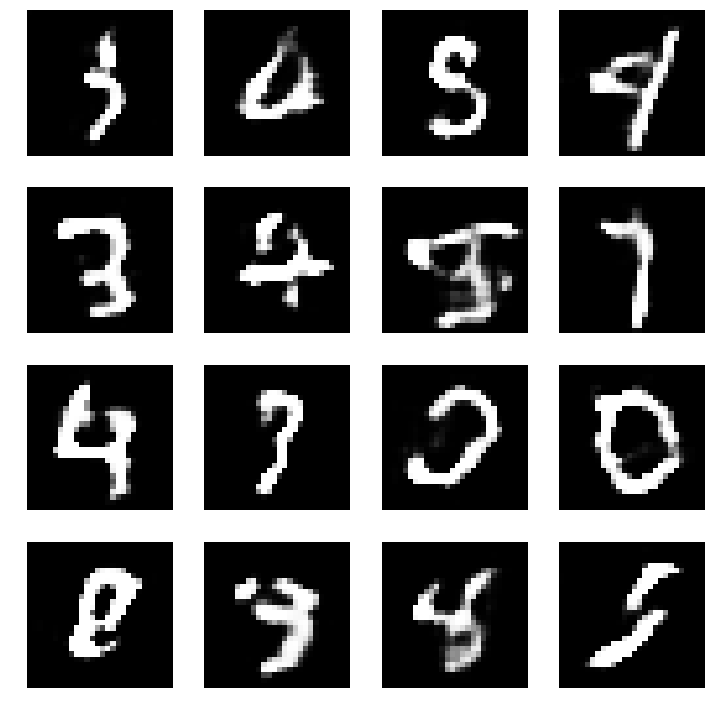

In [11]:
if __name__ == '__main__':
    mnist_dcgan = MNIST_DCGAN()
    mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=500)
    mnist_dcgan.plot_images(fake=True)
    mnist_dcgan.plot_images(fake=False, save2file=True)

0: [D loss: 0.664667, acc: 0.580078]: [A loss: 0.738886, acc: 0.429688]
1: [D loss: 0.709825, acc: 0.531250]: [A loss: 1.130259, acc: 0.023438]
2: [D loss: 0.668784, acc: 0.597656]: [A loss: 0.677219, acc: 0.558594]
3: [D loss: 0.694586, acc: 0.525391]: [A loss: 1.096853, acc: 0.062500]
4: [D loss: 0.653423, acc: 0.640625]: [A loss: 0.777022, acc: 0.320312]
5: [D loss: 0.691917, acc: 0.556641]: [A loss: 1.023301, acc: 0.050781]
6: [D loss: 0.654527, acc: 0.617188]: [A loss: 0.784455, acc: 0.332031]
7: [D loss: 0.678461, acc: 0.554688]: [A loss: 1.029855, acc: 0.050781]
8: [D loss: 0.664468, acc: 0.595703]: [A loss: 0.725829, acc: 0.468750]
9: [D loss: 0.710644, acc: 0.525391]: [A loss: 1.082477, acc: 0.039062]
10: [D loss: 0.672392, acc: 0.580078]: [A loss: 0.702425, acc: 0.535156]
11: [D loss: 0.710547, acc: 0.529297]: [A loss: 1.089906, acc: 0.031250]
12: [D loss: 0.673204, acc: 0.583984]: [A loss: 0.649436, acc: 0.667969]
13: [D loss: 0.716384, acc: 0.527344]: [A loss: 1.075300, acc

113: [D loss: 0.698848, acc: 0.533203]: [A loss: 1.126435, acc: 0.007812]
114: [D loss: 0.673439, acc: 0.589844]: [A loss: 0.712643, acc: 0.441406]
115: [D loss: 0.686743, acc: 0.546875]: [A loss: 1.008965, acc: 0.066406]
116: [D loss: 0.679703, acc: 0.548828]: [A loss: 0.721410, acc: 0.464844]
117: [D loss: 0.700700, acc: 0.539062]: [A loss: 1.097959, acc: 0.042969]
118: [D loss: 0.665375, acc: 0.593750]: [A loss: 0.698667, acc: 0.531250]
119: [D loss: 0.710357, acc: 0.537109]: [A loss: 1.099703, acc: 0.003906]
120: [D loss: 0.679035, acc: 0.564453]: [A loss: 0.660332, acc: 0.562500]
121: [D loss: 0.706958, acc: 0.541016]: [A loss: 1.017741, acc: 0.046875]
122: [D loss: 0.688661, acc: 0.556641]: [A loss: 0.708966, acc: 0.484375]
123: [D loss: 0.688581, acc: 0.560547]: [A loss: 0.904056, acc: 0.109375]
124: [D loss: 0.682179, acc: 0.566406]: [A loss: 0.770041, acc: 0.320312]
125: [D loss: 0.683242, acc: 0.566406]: [A loss: 0.892572, acc: 0.128906]
126: [D loss: 0.671607, acc: 0.609375]

224: [D loss: 0.676216, acc: 0.574219]: [A loss: 0.961161, acc: 0.093750]
225: [D loss: 0.663110, acc: 0.621094]: [A loss: 0.770642, acc: 0.343750]
226: [D loss: 0.676504, acc: 0.572266]: [A loss: 0.964865, acc: 0.066406]
227: [D loss: 0.658549, acc: 0.613281]: [A loss: 0.712174, acc: 0.480469]
228: [D loss: 0.699395, acc: 0.541016]: [A loss: 1.041339, acc: 0.019531]
229: [D loss: 0.680081, acc: 0.537109]: [A loss: 0.728917, acc: 0.457031]
230: [D loss: 0.712079, acc: 0.527344]: [A loss: 1.062457, acc: 0.031250]
231: [D loss: 0.681764, acc: 0.546875]: [A loss: 0.669390, acc: 0.566406]
232: [D loss: 0.718618, acc: 0.515625]: [A loss: 0.958899, acc: 0.093750]
233: [D loss: 0.670645, acc: 0.589844]: [A loss: 0.719568, acc: 0.468750]
234: [D loss: 0.704035, acc: 0.494141]: [A loss: 0.938947, acc: 0.093750]
235: [D loss: 0.679908, acc: 0.568359]: [A loss: 0.777031, acc: 0.339844]
236: [D loss: 0.680636, acc: 0.572266]: [A loss: 0.919896, acc: 0.105469]
237: [D loss: 0.660661, acc: 0.619141]

335: [D loss: 0.694730, acc: 0.509766]: [A loss: 0.918195, acc: 0.121094]
336: [D loss: 0.684309, acc: 0.560547]: [A loss: 0.718226, acc: 0.464844]
337: [D loss: 0.693532, acc: 0.542969]: [A loss: 0.903086, acc: 0.121094]
338: [D loss: 0.685469, acc: 0.560547]: [A loss: 0.782159, acc: 0.347656]
339: [D loss: 0.682215, acc: 0.537109]: [A loss: 0.839023, acc: 0.183594]
340: [D loss: 0.687467, acc: 0.552734]: [A loss: 0.770488, acc: 0.312500]
341: [D loss: 0.697475, acc: 0.550781]: [A loss: 0.873671, acc: 0.140625]
342: [D loss: 0.686292, acc: 0.558594]: [A loss: 0.807855, acc: 0.242188]
343: [D loss: 0.690493, acc: 0.523438]: [A loss: 0.882266, acc: 0.136719]
344: [D loss: 0.684989, acc: 0.572266]: [A loss: 0.795613, acc: 0.265625]
345: [D loss: 0.672818, acc: 0.556641]: [A loss: 0.854230, acc: 0.156250]
346: [D loss: 0.675879, acc: 0.574219]: [A loss: 0.764557, acc: 0.339844]
347: [D loss: 0.683092, acc: 0.558594]: [A loss: 0.890639, acc: 0.144531]
348: [D loss: 0.672344, acc: 0.587891]

446: [D loss: 0.685254, acc: 0.568359]: [A loss: 0.805585, acc: 0.253906]
447: [D loss: 0.680180, acc: 0.570312]: [A loss: 0.857998, acc: 0.167969]
448: [D loss: 0.676981, acc: 0.574219]: [A loss: 0.800767, acc: 0.281250]
449: [D loss: 0.690243, acc: 0.552734]: [A loss: 0.874400, acc: 0.156250]
450: [D loss: 0.697071, acc: 0.517578]: [A loss: 0.830940, acc: 0.238281]
451: [D loss: 0.692224, acc: 0.541016]: [A loss: 0.854503, acc: 0.132812]
452: [D loss: 0.676824, acc: 0.578125]: [A loss: 0.815865, acc: 0.218750]
453: [D loss: 0.685402, acc: 0.562500]: [A loss: 0.847163, acc: 0.195312]
454: [D loss: 0.691569, acc: 0.548828]: [A loss: 0.798360, acc: 0.277344]
455: [D loss: 0.677389, acc: 0.556641]: [A loss: 0.910719, acc: 0.117188]
456: [D loss: 0.703947, acc: 0.505859]: [A loss: 0.747044, acc: 0.363281]
457: [D loss: 0.709537, acc: 0.488281]: [A loss: 0.983266, acc: 0.050781]
458: [D loss: 0.684399, acc: 0.544922]: [A loss: 0.629595, acc: 0.703125]
459: [D loss: 0.720365, acc: 0.521484]

557: [D loss: 0.702536, acc: 0.517578]: [A loss: 0.913345, acc: 0.085938]
558: [D loss: 0.693369, acc: 0.544922]: [A loss: 0.692206, acc: 0.507812]
559: [D loss: 0.691843, acc: 0.531250]: [A loss: 0.865289, acc: 0.125000]
560: [D loss: 0.680789, acc: 0.570312]: [A loss: 0.774914, acc: 0.308594]
561: [D loss: 0.694040, acc: 0.558594]: [A loss: 0.843089, acc: 0.167969]
562: [D loss: 0.690867, acc: 0.529297]: [A loss: 0.751413, acc: 0.359375]
563: [D loss: 0.696586, acc: 0.531250]: [A loss: 0.804449, acc: 0.207031]
564: [D loss: 0.691144, acc: 0.517578]: [A loss: 0.756817, acc: 0.355469]
565: [D loss: 0.690360, acc: 0.554688]: [A loss: 0.833992, acc: 0.203125]
566: [D loss: 0.691373, acc: 0.535156]: [A loss: 0.785807, acc: 0.292969]
567: [D loss: 0.686565, acc: 0.527344]: [A loss: 0.865078, acc: 0.140625]
568: [D loss: 0.681091, acc: 0.535156]: [A loss: 0.768031, acc: 0.320312]
569: [D loss: 0.689005, acc: 0.548828]: [A loss: 0.905785, acc: 0.101562]
570: [D loss: 0.686120, acc: 0.570312]

668: [D loss: 0.704296, acc: 0.531250]: [A loss: 0.898147, acc: 0.128906]
669: [D loss: 0.690032, acc: 0.546875]: [A loss: 0.664127, acc: 0.566406]
670: [D loss: 0.713066, acc: 0.544922]: [A loss: 0.857165, acc: 0.160156]
671: [D loss: 0.690171, acc: 0.515625]: [A loss: 0.726684, acc: 0.425781]
672: [D loss: 0.682141, acc: 0.554688]: [A loss: 0.790359, acc: 0.273438]
673: [D loss: 0.693841, acc: 0.523438]: [A loss: 0.790219, acc: 0.242188]
674: [D loss: 0.696029, acc: 0.541016]: [A loss: 0.794266, acc: 0.234375]
675: [D loss: 0.677050, acc: 0.587891]: [A loss: 0.744656, acc: 0.355469]
676: [D loss: 0.692657, acc: 0.525391]: [A loss: 0.846101, acc: 0.167969]
677: [D loss: 0.686222, acc: 0.541016]: [A loss: 0.691270, acc: 0.515625]
678: [D loss: 0.697203, acc: 0.519531]: [A loss: 0.879521, acc: 0.101562]
679: [D loss: 0.699728, acc: 0.501953]: [A loss: 0.683279, acc: 0.546875]
680: [D loss: 0.696797, acc: 0.552734]: [A loss: 0.845385, acc: 0.144531]
681: [D loss: 0.684671, acc: 0.574219]

779: [D loss: 0.700688, acc: 0.529297]: [A loss: 0.820997, acc: 0.187500]
780: [D loss: 0.682713, acc: 0.556641]: [A loss: 0.693749, acc: 0.515625]
781: [D loss: 0.700095, acc: 0.531250]: [A loss: 0.863835, acc: 0.113281]
782: [D loss: 0.687738, acc: 0.564453]: [A loss: 0.689586, acc: 0.531250]
783: [D loss: 0.699907, acc: 0.523438]: [A loss: 0.842430, acc: 0.113281]
784: [D loss: 0.684995, acc: 0.556641]: [A loss: 0.711771, acc: 0.464844]
785: [D loss: 0.690613, acc: 0.548828]: [A loss: 0.812411, acc: 0.167969]
786: [D loss: 0.692791, acc: 0.537109]: [A loss: 0.747828, acc: 0.335938]
787: [D loss: 0.683474, acc: 0.558594]: [A loss: 0.785616, acc: 0.234375]
788: [D loss: 0.686077, acc: 0.537109]: [A loss: 0.776223, acc: 0.281250]
789: [D loss: 0.688418, acc: 0.541016]: [A loss: 0.770236, acc: 0.289062]
790: [D loss: 0.693647, acc: 0.556641]: [A loss: 0.804581, acc: 0.195312]
791: [D loss: 0.709207, acc: 0.486328]: [A loss: 0.800745, acc: 0.214844]
792: [D loss: 0.692608, acc: 0.521484]

890: [D loss: 0.707232, acc: 0.486328]: [A loss: 0.814067, acc: 0.140625]
891: [D loss: 0.689920, acc: 0.539062]: [A loss: 0.718246, acc: 0.398438]
892: [D loss: 0.708262, acc: 0.470703]: [A loss: 0.789319, acc: 0.218750]
893: [D loss: 0.690053, acc: 0.527344]: [A loss: 0.747698, acc: 0.312500]
894: [D loss: 0.694911, acc: 0.527344]: [A loss: 0.771453, acc: 0.257812]
895: [D loss: 0.691887, acc: 0.531250]: [A loss: 0.748735, acc: 0.351562]
896: [D loss: 0.692659, acc: 0.529297]: [A loss: 0.717496, acc: 0.402344]
897: [D loss: 0.702802, acc: 0.484375]: [A loss: 0.763232, acc: 0.234375]
898: [D loss: 0.695902, acc: 0.509766]: [A loss: 0.750269, acc: 0.339844]
899: [D loss: 0.689310, acc: 0.544922]: [A loss: 0.763895, acc: 0.277344]
900: [D loss: 0.707598, acc: 0.488281]: [A loss: 0.783657, acc: 0.199219]
901: [D loss: 0.684603, acc: 0.535156]: [A loss: 0.708325, acc: 0.464844]
902: [D loss: 0.693881, acc: 0.539062]: [A loss: 0.794608, acc: 0.214844]
903: [D loss: 0.696344, acc: 0.496094]

1001: [D loss: 0.694972, acc: 0.523438]: [A loss: 0.650265, acc: 0.675781]
1002: [D loss: 0.714175, acc: 0.505859]: [A loss: 0.819396, acc: 0.117188]
1003: [D loss: 0.700347, acc: 0.480469]: [A loss: 0.699711, acc: 0.511719]
1004: [D loss: 0.697007, acc: 0.546875]: [A loss: 0.808418, acc: 0.144531]
1005: [D loss: 0.691046, acc: 0.533203]: [A loss: 0.692452, acc: 0.531250]
1006: [D loss: 0.696399, acc: 0.521484]: [A loss: 0.784829, acc: 0.242188]
1007: [D loss: 0.695070, acc: 0.496094]: [A loss: 0.750922, acc: 0.316406]
1008: [D loss: 0.696820, acc: 0.521484]: [A loss: 0.779539, acc: 0.246094]
1009: [D loss: 0.695185, acc: 0.511719]: [A loss: 0.767037, acc: 0.269531]
1010: [D loss: 0.690566, acc: 0.515625]: [A loss: 0.713626, acc: 0.441406]
1011: [D loss: 0.700100, acc: 0.509766]: [A loss: 0.759721, acc: 0.250000]
1012: [D loss: 0.694052, acc: 0.507812]: [A loss: 0.717932, acc: 0.445312]
1013: [D loss: 0.689292, acc: 0.544922]: [A loss: 0.786767, acc: 0.257812]
1014: [D loss: 0.683190, 

1111: [D loss: 0.694883, acc: 0.548828]: [A loss: 0.828190, acc: 0.101562]
1112: [D loss: 0.674796, acc: 0.593750]: [A loss: 0.727610, acc: 0.429688]
1113: [D loss: 0.701250, acc: 0.509766]: [A loss: 0.796558, acc: 0.171875]
1114: [D loss: 0.690663, acc: 0.527344]: [A loss: 0.710191, acc: 0.425781]
1115: [D loss: 0.692811, acc: 0.519531]: [A loss: 0.817866, acc: 0.156250]
1116: [D loss: 0.701893, acc: 0.500000]: [A loss: 0.698227, acc: 0.468750]
1117: [D loss: 0.691862, acc: 0.511719]: [A loss: 0.849192, acc: 0.093750]
1118: [D loss: 0.695565, acc: 0.527344]: [A loss: 0.682986, acc: 0.566406]
1119: [D loss: 0.690041, acc: 0.533203]: [A loss: 0.781926, acc: 0.210938]
1120: [D loss: 0.701452, acc: 0.505859]: [A loss: 0.725170, acc: 0.355469]
1121: [D loss: 0.699457, acc: 0.539062]: [A loss: 0.791433, acc: 0.175781]
1122: [D loss: 0.687452, acc: 0.521484]: [A loss: 0.719903, acc: 0.445312]
1123: [D loss: 0.696925, acc: 0.513672]: [A loss: 0.766328, acc: 0.218750]
1124: [D loss: 0.688907, 

1221: [D loss: 0.684799, acc: 0.570312]: [A loss: 0.752035, acc: 0.296875]
1222: [D loss: 0.690700, acc: 0.535156]: [A loss: 0.737227, acc: 0.363281]
1223: [D loss: 0.697694, acc: 0.537109]: [A loss: 0.751559, acc: 0.273438]
1224: [D loss: 0.692332, acc: 0.527344]: [A loss: 0.767219, acc: 0.273438]
1225: [D loss: 0.694672, acc: 0.503906]: [A loss: 0.793500, acc: 0.214844]
1226: [D loss: 0.689795, acc: 0.535156]: [A loss: 0.698149, acc: 0.531250]
1227: [D loss: 0.694661, acc: 0.525391]: [A loss: 0.844182, acc: 0.078125]
1228: [D loss: 0.687521, acc: 0.521484]: [A loss: 0.669355, acc: 0.617188]
1229: [D loss: 0.702338, acc: 0.503906]: [A loss: 0.823720, acc: 0.132812]
1230: [D loss: 0.691497, acc: 0.542969]: [A loss: 0.696624, acc: 0.480469]
1231: [D loss: 0.700285, acc: 0.513672]: [A loss: 0.825649, acc: 0.140625]
1232: [D loss: 0.696309, acc: 0.519531]: [A loss: 0.708967, acc: 0.476562]
1233: [D loss: 0.698591, acc: 0.500000]: [A loss: 0.797785, acc: 0.191406]
1234: [D loss: 0.692166, 

1331: [D loss: 0.706400, acc: 0.539062]: [A loss: 0.876977, acc: 0.066406]
1332: [D loss: 0.693817, acc: 0.509766]: [A loss: 0.665548, acc: 0.605469]
1333: [D loss: 0.705629, acc: 0.501953]: [A loss: 0.850183, acc: 0.062500]
1334: [D loss: 0.688286, acc: 0.558594]: [A loss: 0.669896, acc: 0.582031]
1335: [D loss: 0.706276, acc: 0.492188]: [A loss: 0.801024, acc: 0.156250]
1336: [D loss: 0.689228, acc: 0.537109]: [A loss: 0.770722, acc: 0.207031]
1337: [D loss: 0.692907, acc: 0.509766]: [A loss: 0.774599, acc: 0.222656]
1338: [D loss: 0.682110, acc: 0.574219]: [A loss: 0.756558, acc: 0.328125]
1339: [D loss: 0.694110, acc: 0.529297]: [A loss: 0.736992, acc: 0.324219]
1340: [D loss: 0.692266, acc: 0.519531]: [A loss: 0.764399, acc: 0.257812]
1341: [D loss: 0.689798, acc: 0.529297]: [A loss: 0.693963, acc: 0.519531]
1342: [D loss: 0.703977, acc: 0.525391]: [A loss: 0.835337, acc: 0.113281]
1343: [D loss: 0.688412, acc: 0.552734]: [A loss: 0.695527, acc: 0.507812]
1344: [D loss: 0.705057, 

1441: [D loss: 0.689977, acc: 0.525391]: [A loss: 0.686244, acc: 0.546875]
1442: [D loss: 0.695856, acc: 0.492188]: [A loss: 0.814441, acc: 0.132812]
1443: [D loss: 0.692568, acc: 0.541016]: [A loss: 0.692807, acc: 0.531250]
1444: [D loss: 0.704024, acc: 0.500000]: [A loss: 0.811887, acc: 0.113281]
1445: [D loss: 0.692911, acc: 0.539062]: [A loss: 0.700400, acc: 0.484375]
1446: [D loss: 0.698852, acc: 0.527344]: [A loss: 0.803443, acc: 0.183594]
1447: [D loss: 0.691491, acc: 0.537109]: [A loss: 0.744986, acc: 0.277344]
1448: [D loss: 0.693663, acc: 0.537109]: [A loss: 0.739338, acc: 0.378906]
1449: [D loss: 0.694835, acc: 0.505859]: [A loss: 0.730040, acc: 0.390625]
1450: [D loss: 0.698275, acc: 0.533203]: [A loss: 0.749053, acc: 0.308594]
1451: [D loss: 0.694406, acc: 0.529297]: [A loss: 0.726797, acc: 0.371094]
1452: [D loss: 0.696766, acc: 0.511719]: [A loss: 0.743061, acc: 0.335938]
1453: [D loss: 0.690901, acc: 0.529297]: [A loss: 0.765246, acc: 0.246094]
1454: [D loss: 0.694529, 

1551: [D loss: 0.687012, acc: 0.539062]: [A loss: 0.726975, acc: 0.351562]
1552: [D loss: 0.688638, acc: 0.535156]: [A loss: 0.737866, acc: 0.316406]
1553: [D loss: 0.701367, acc: 0.503906]: [A loss: 0.737738, acc: 0.320312]
1554: [D loss: 0.699250, acc: 0.515625]: [A loss: 0.717965, acc: 0.425781]
1555: [D loss: 0.692327, acc: 0.525391]: [A loss: 0.761457, acc: 0.246094]
1556: [D loss: 0.698728, acc: 0.488281]: [A loss: 0.707812, acc: 0.425781]
1557: [D loss: 0.692362, acc: 0.525391]: [A loss: 0.725010, acc: 0.375000]
1558: [D loss: 0.691103, acc: 0.513672]: [A loss: 0.733332, acc: 0.355469]
1559: [D loss: 0.699272, acc: 0.505859]: [A loss: 0.763280, acc: 0.222656]
1560: [D loss: 0.706624, acc: 0.458984]: [A loss: 0.776570, acc: 0.207031]
1561: [D loss: 0.697022, acc: 0.515625]: [A loss: 0.738702, acc: 0.335938]
1562: [D loss: 0.694733, acc: 0.523438]: [A loss: 0.734955, acc: 0.335938]
1563: [D loss: 0.688820, acc: 0.544922]: [A loss: 0.750104, acc: 0.300781]
1564: [D loss: 0.695669, 

1661: [D loss: 0.690272, acc: 0.533203]: [A loss: 0.701028, acc: 0.472656]
1662: [D loss: 0.694063, acc: 0.507812]: [A loss: 0.758952, acc: 0.210938]
1663: [D loss: 0.697013, acc: 0.492188]: [A loss: 0.721754, acc: 0.382812]
1664: [D loss: 0.692360, acc: 0.550781]: [A loss: 0.746119, acc: 0.269531]
1665: [D loss: 0.683066, acc: 0.554688]: [A loss: 0.763192, acc: 0.269531]
1666: [D loss: 0.697011, acc: 0.513672]: [A loss: 0.682735, acc: 0.570312]
1667: [D loss: 0.698024, acc: 0.527344]: [A loss: 0.791175, acc: 0.160156]
1668: [D loss: 0.690858, acc: 0.517578]: [A loss: 0.677043, acc: 0.574219]
1669: [D loss: 0.697101, acc: 0.521484]: [A loss: 0.807525, acc: 0.140625]
1670: [D loss: 0.694423, acc: 0.519531]: [A loss: 0.713089, acc: 0.398438]
1671: [D loss: 0.688956, acc: 0.537109]: [A loss: 0.779094, acc: 0.171875]
1672: [D loss: 0.696356, acc: 0.511719]: [A loss: 0.730140, acc: 0.339844]
1673: [D loss: 0.698526, acc: 0.480469]: [A loss: 0.758357, acc: 0.261719]
1674: [D loss: 0.696871, 

1771: [D loss: 0.699495, acc: 0.509766]: [A loss: 0.771046, acc: 0.210938]
1772: [D loss: 0.696699, acc: 0.482422]: [A loss: 0.746737, acc: 0.273438]
1773: [D loss: 0.700189, acc: 0.509766]: [A loss: 0.757620, acc: 0.257812]
1774: [D loss: 0.701209, acc: 0.498047]: [A loss: 0.717552, acc: 0.421875]
1775: [D loss: 0.689711, acc: 0.531250]: [A loss: 0.726629, acc: 0.335938]
1776: [D loss: 0.696417, acc: 0.490234]: [A loss: 0.699442, acc: 0.449219]
1777: [D loss: 0.691542, acc: 0.542969]: [A loss: 0.745286, acc: 0.281250]
1778: [D loss: 0.695028, acc: 0.527344]: [A loss: 0.717428, acc: 0.378906]
1779: [D loss: 0.704813, acc: 0.488281]: [A loss: 0.777775, acc: 0.167969]
1780: [D loss: 0.695987, acc: 0.529297]: [A loss: 0.689866, acc: 0.507812]
1781: [D loss: 0.701455, acc: 0.496094]: [A loss: 0.774373, acc: 0.191406]
1782: [D loss: 0.691995, acc: 0.541016]: [A loss: 0.686827, acc: 0.507812]
1783: [D loss: 0.705330, acc: 0.501953]: [A loss: 0.772630, acc: 0.183594]
1784: [D loss: 0.695531, 

1881: [D loss: 0.702373, acc: 0.496094]: [A loss: 0.741421, acc: 0.265625]
1882: [D loss: 0.694813, acc: 0.529297]: [A loss: 0.736309, acc: 0.335938]
1883: [D loss: 0.690633, acc: 0.507812]: [A loss: 0.730029, acc: 0.347656]
1884: [D loss: 0.697038, acc: 0.507812]: [A loss: 0.699100, acc: 0.488281]
1885: [D loss: 0.697305, acc: 0.515625]: [A loss: 0.777835, acc: 0.156250]
1886: [D loss: 0.701568, acc: 0.484375]: [A loss: 0.686304, acc: 0.539062]
1887: [D loss: 0.700670, acc: 0.501953]: [A loss: 0.735200, acc: 0.269531]
1888: [D loss: 0.694946, acc: 0.519531]: [A loss: 0.667532, acc: 0.628906]
1889: [D loss: 0.697315, acc: 0.507812]: [A loss: 0.756494, acc: 0.203125]
1890: [D loss: 0.690306, acc: 0.531250]: [A loss: 0.725752, acc: 0.332031]
1891: [D loss: 0.689596, acc: 0.513672]: [A loss: 0.716033, acc: 0.398438]
1892: [D loss: 0.704726, acc: 0.472656]: [A loss: 0.786792, acc: 0.136719]
1893: [D loss: 0.693971, acc: 0.527344]: [A loss: 0.693314, acc: 0.519531]
1894: [D loss: 0.699804, 

1991: [D loss: 0.692833, acc: 0.544922]: [A loss: 0.708704, acc: 0.437500]
1992: [D loss: 0.694613, acc: 0.490234]: [A loss: 0.722820, acc: 0.320312]
1993: [D loss: 0.694833, acc: 0.521484]: [A loss: 0.744415, acc: 0.308594]
1994: [D loss: 0.696483, acc: 0.500000]: [A loss: 0.703119, acc: 0.484375]
1995: [D loss: 0.696205, acc: 0.521484]: [A loss: 0.757683, acc: 0.187500]
1996: [D loss: 0.688147, acc: 0.544922]: [A loss: 0.677066, acc: 0.628906]
1997: [D loss: 0.701402, acc: 0.503906]: [A loss: 0.757949, acc: 0.226562]
1998: [D loss: 0.698853, acc: 0.476562]: [A loss: 0.697879, acc: 0.488281]
1999: [D loss: 0.697966, acc: 0.496094]: [A loss: 0.739035, acc: 0.261719]
2000: [D loss: 0.697415, acc: 0.455078]: [A loss: 0.718354, acc: 0.386719]
2001: [D loss: 0.699092, acc: 0.513672]: [A loss: 0.709016, acc: 0.406250]
2002: [D loss: 0.689251, acc: 0.515625]: [A loss: 0.719320, acc: 0.351562]
2003: [D loss: 0.692808, acc: 0.519531]: [A loss: 0.720183, acc: 0.335938]
2004: [D loss: 0.685790, 

2101: [D loss: 0.697247, acc: 0.494141]: [A loss: 0.731889, acc: 0.296875]
2102: [D loss: 0.695676, acc: 0.521484]: [A loss: 0.758293, acc: 0.226562]
2103: [D loss: 0.692810, acc: 0.511719]: [A loss: 0.729503, acc: 0.332031]
2104: [D loss: 0.695285, acc: 0.500000]: [A loss: 0.689157, acc: 0.535156]
2105: [D loss: 0.696830, acc: 0.505859]: [A loss: 0.740568, acc: 0.269531]
2106: [D loss: 0.693381, acc: 0.529297]: [A loss: 0.719833, acc: 0.394531]
2107: [D loss: 0.691469, acc: 0.531250]: [A loss: 0.744507, acc: 0.285156]
2108: [D loss: 0.691309, acc: 0.527344]: [A loss: 0.696151, acc: 0.488281]
2109: [D loss: 0.698845, acc: 0.503906]: [A loss: 0.749326, acc: 0.230469]
2110: [D loss: 0.694174, acc: 0.458984]: [A loss: 0.709384, acc: 0.410156]
2111: [D loss: 0.694402, acc: 0.503906]: [A loss: 0.731279, acc: 0.320312]
2112: [D loss: 0.694403, acc: 0.533203]: [A loss: 0.721059, acc: 0.371094]
2113: [D loss: 0.693692, acc: 0.511719]: [A loss: 0.752116, acc: 0.253906]
2114: [D loss: 0.697117, 

2211: [D loss: 0.693226, acc: 0.535156]: [A loss: 0.742700, acc: 0.269531]
2212: [D loss: 0.698460, acc: 0.478516]: [A loss: 0.736148, acc: 0.292969]
2213: [D loss: 0.690212, acc: 0.531250]: [A loss: 0.686496, acc: 0.562500]
2214: [D loss: 0.700426, acc: 0.498047]: [A loss: 0.764403, acc: 0.179688]
2215: [D loss: 0.688566, acc: 0.525391]: [A loss: 0.699225, acc: 0.480469]
2216: [D loss: 0.695285, acc: 0.488281]: [A loss: 0.715504, acc: 0.390625]
2217: [D loss: 0.692553, acc: 0.523438]: [A loss: 0.741602, acc: 0.281250]
2218: [D loss: 0.697384, acc: 0.500000]: [A loss: 0.671109, acc: 0.632812]
2219: [D loss: 0.699485, acc: 0.519531]: [A loss: 0.750089, acc: 0.218750]
2220: [D loss: 0.697573, acc: 0.494141]: [A loss: 0.680473, acc: 0.566406]
2221: [D loss: 0.701601, acc: 0.500000]: [A loss: 0.742759, acc: 0.246094]
2222: [D loss: 0.692439, acc: 0.523438]: [A loss: 0.693491, acc: 0.496094]
2223: [D loss: 0.690692, acc: 0.517578]: [A loss: 0.722755, acc: 0.378906]
2224: [D loss: 0.692475, 

2321: [D loss: 0.692613, acc: 0.531250]: [A loss: 0.707650, acc: 0.441406]
2322: [D loss: 0.698686, acc: 0.503906]: [A loss: 0.719149, acc: 0.390625]
2323: [D loss: 0.695706, acc: 0.531250]: [A loss: 0.734829, acc: 0.300781]
2324: [D loss: 0.696401, acc: 0.498047]: [A loss: 0.735917, acc: 0.296875]
2325: [D loss: 0.700577, acc: 0.490234]: [A loss: 0.745305, acc: 0.281250]
2326: [D loss: 0.697975, acc: 0.478516]: [A loss: 0.685093, acc: 0.535156]
2327: [D loss: 0.701603, acc: 0.513672]: [A loss: 0.792436, acc: 0.125000]
2328: [D loss: 0.694426, acc: 0.503906]: [A loss: 0.678515, acc: 0.585938]
2329: [D loss: 0.700066, acc: 0.521484]: [A loss: 0.764938, acc: 0.179688]
2330: [D loss: 0.691185, acc: 0.523438]: [A loss: 0.693667, acc: 0.484375]
2331: [D loss: 0.699127, acc: 0.509766]: [A loss: 0.746873, acc: 0.246094]
2332: [D loss: 0.692175, acc: 0.500000]: [A loss: 0.727590, acc: 0.308594]
2333: [D loss: 0.688983, acc: 0.546875]: [A loss: 0.735459, acc: 0.277344]
2334: [D loss: 0.700737, 

2431: [D loss: 0.684867, acc: 0.564453]: [A loss: 0.683787, acc: 0.570312]
2432: [D loss: 0.699820, acc: 0.521484]: [A loss: 0.715543, acc: 0.417969]
2433: [D loss: 0.701590, acc: 0.478516]: [A loss: 0.708843, acc: 0.414062]
2434: [D loss: 0.696862, acc: 0.539062]: [A loss: 0.781748, acc: 0.148438]
2435: [D loss: 0.693467, acc: 0.521484]: [A loss: 0.693422, acc: 0.484375]
2436: [D loss: 0.693773, acc: 0.531250]: [A loss: 0.718801, acc: 0.414062]
2437: [D loss: 0.695736, acc: 0.507812]: [A loss: 0.719398, acc: 0.375000]
2438: [D loss: 0.693542, acc: 0.519531]: [A loss: 0.714675, acc: 0.417969]
2439: [D loss: 0.694628, acc: 0.513672]: [A loss: 0.730394, acc: 0.332031]
2440: [D loss: 0.699263, acc: 0.492188]: [A loss: 0.729174, acc: 0.304688]
2441: [D loss: 0.698867, acc: 0.500000]: [A loss: 0.700317, acc: 0.472656]
2442: [D loss: 0.693228, acc: 0.509766]: [A loss: 0.729225, acc: 0.304688]
2443: [D loss: 0.688325, acc: 0.546875]: [A loss: 0.714445, acc: 0.433594]
2444: [D loss: 0.696936, 

2541: [D loss: 0.697552, acc: 0.501953]: [A loss: 0.698239, acc: 0.468750]
2542: [D loss: 0.706560, acc: 0.507812]: [A loss: 0.778414, acc: 0.132812]
2543: [D loss: 0.691313, acc: 0.500000]: [A loss: 0.682513, acc: 0.574219]
2544: [D loss: 0.697496, acc: 0.527344]: [A loss: 0.722436, acc: 0.359375]
2545: [D loss: 0.695303, acc: 0.500000]: [A loss: 0.731122, acc: 0.304688]
2546: [D loss: 0.693070, acc: 0.505859]: [A loss: 0.720523, acc: 0.371094]
2547: [D loss: 0.696246, acc: 0.503906]: [A loss: 0.740530, acc: 0.296875]
2548: [D loss: 0.695713, acc: 0.500000]: [A loss: 0.722935, acc: 0.375000]
2549: [D loss: 0.700025, acc: 0.511719]: [A loss: 0.711622, acc: 0.417969]
2550: [D loss: 0.694555, acc: 0.509766]: [A loss: 0.747681, acc: 0.226562]
2551: [D loss: 0.702294, acc: 0.476562]: [A loss: 0.710641, acc: 0.390625]
2552: [D loss: 0.690089, acc: 0.535156]: [A loss: 0.691677, acc: 0.511719]
2553: [D loss: 0.701406, acc: 0.501953]: [A loss: 0.760803, acc: 0.203125]
2554: [D loss: 0.692632, 

2651: [D loss: 0.695393, acc: 0.492188]: [A loss: 0.721012, acc: 0.332031]
2652: [D loss: 0.693579, acc: 0.519531]: [A loss: 0.706456, acc: 0.441406]
2653: [D loss: 0.698532, acc: 0.500000]: [A loss: 0.755789, acc: 0.207031]
2654: [D loss: 0.690606, acc: 0.525391]: [A loss: 0.718755, acc: 0.363281]
2655: [D loss: 0.695578, acc: 0.529297]: [A loss: 0.733634, acc: 0.292969]
2656: [D loss: 0.696504, acc: 0.505859]: [A loss: 0.747962, acc: 0.246094]
2657: [D loss: 0.693663, acc: 0.517578]: [A loss: 0.696435, acc: 0.460938]
2658: [D loss: 0.696516, acc: 0.507812]: [A loss: 0.741023, acc: 0.265625]
2659: [D loss: 0.692663, acc: 0.513672]: [A loss: 0.699013, acc: 0.496094]
2660: [D loss: 0.696439, acc: 0.521484]: [A loss: 0.765103, acc: 0.210938]
2661: [D loss: 0.699641, acc: 0.472656]: [A loss: 0.702766, acc: 0.480469]
2662: [D loss: 0.694712, acc: 0.537109]: [A loss: 0.750442, acc: 0.246094]
2663: [D loss: 0.688700, acc: 0.537109]: [A loss: 0.700149, acc: 0.460938]
2664: [D loss: 0.690888, 

2761: [D loss: 0.703449, acc: 0.513672]: [A loss: 0.740314, acc: 0.261719]
2762: [D loss: 0.695830, acc: 0.515625]: [A loss: 0.720405, acc: 0.371094]
2763: [D loss: 0.696540, acc: 0.503906]: [A loss: 0.692303, acc: 0.507812]
2764: [D loss: 0.695752, acc: 0.509766]: [A loss: 0.746969, acc: 0.230469]
2765: [D loss: 0.689673, acc: 0.546875]: [A loss: 0.701415, acc: 0.433594]
2766: [D loss: 0.702813, acc: 0.503906]: [A loss: 0.749821, acc: 0.230469]
2767: [D loss: 0.686667, acc: 0.546875]: [A loss: 0.700955, acc: 0.472656]
2768: [D loss: 0.695926, acc: 0.517578]: [A loss: 0.716107, acc: 0.386719]
2769: [D loss: 0.688848, acc: 0.533203]: [A loss: 0.705315, acc: 0.406250]
2770: [D loss: 0.699219, acc: 0.513672]: [A loss: 0.746566, acc: 0.253906]
2771: [D loss: 0.697917, acc: 0.513672]: [A loss: 0.719548, acc: 0.359375]
2772: [D loss: 0.699967, acc: 0.494141]: [A loss: 0.726485, acc: 0.289062]
2773: [D loss: 0.688185, acc: 0.529297]: [A loss: 0.726828, acc: 0.320312]
2774: [D loss: 0.690427, 

2871: [D loss: 0.694990, acc: 0.505859]: [A loss: 0.684983, acc: 0.593750]
2872: [D loss: 0.701524, acc: 0.511719]: [A loss: 0.776925, acc: 0.121094]
2873: [D loss: 0.696237, acc: 0.468750]: [A loss: 0.667600, acc: 0.683594]
2874: [D loss: 0.697682, acc: 0.501953]: [A loss: 0.754391, acc: 0.199219]
2875: [D loss: 0.691271, acc: 0.521484]: [A loss: 0.684812, acc: 0.546875]
2876: [D loss: 0.695516, acc: 0.517578]: [A loss: 0.737866, acc: 0.246094]
2877: [D loss: 0.689731, acc: 0.539062]: [A loss: 0.702100, acc: 0.468750]
2878: [D loss: 0.698839, acc: 0.478516]: [A loss: 0.688850, acc: 0.507812]
2879: [D loss: 0.694253, acc: 0.511719]: [A loss: 0.731359, acc: 0.269531]
2880: [D loss: 0.692176, acc: 0.544922]: [A loss: 0.732363, acc: 0.261719]
2881: [D loss: 0.696439, acc: 0.498047]: [A loss: 0.710243, acc: 0.406250]
2882: [D loss: 0.687634, acc: 0.554688]: [A loss: 0.692491, acc: 0.503906]
2883: [D loss: 0.696303, acc: 0.501953]: [A loss: 0.744208, acc: 0.214844]
2884: [D loss: 0.695764, 

2981: [D loss: 0.693130, acc: 0.525391]: [A loss: 0.730940, acc: 0.253906]
2982: [D loss: 0.691204, acc: 0.521484]: [A loss: 0.693963, acc: 0.468750]
2983: [D loss: 0.696721, acc: 0.488281]: [A loss: 0.697192, acc: 0.488281]
2984: [D loss: 0.700283, acc: 0.466797]: [A loss: 0.747933, acc: 0.144531]
2985: [D loss: 0.691871, acc: 0.527344]: [A loss: 0.699630, acc: 0.445312]
2986: [D loss: 0.695198, acc: 0.490234]: [A loss: 0.734182, acc: 0.234375]
2987: [D loss: 0.692494, acc: 0.500000]: [A loss: 0.698010, acc: 0.460938]
2988: [D loss: 0.691757, acc: 0.511719]: [A loss: 0.697676, acc: 0.468750]
2989: [D loss: 0.692529, acc: 0.486328]: [A loss: 0.699925, acc: 0.476562]
2990: [D loss: 0.693369, acc: 0.509766]: [A loss: 0.702663, acc: 0.437500]
2991: [D loss: 0.699222, acc: 0.505859]: [A loss: 0.737577, acc: 0.218750]
2992: [D loss: 0.688927, acc: 0.548828]: [A loss: 0.739493, acc: 0.230469]
2993: [D loss: 0.695479, acc: 0.517578]: [A loss: 0.705086, acc: 0.378906]
2994: [D loss: 0.695758, 

3091: [D loss: 0.701929, acc: 0.498047]: [A loss: 0.751308, acc: 0.144531]
3092: [D loss: 0.694471, acc: 0.494141]: [A loss: 0.709187, acc: 0.390625]
3093: [D loss: 0.693441, acc: 0.505859]: [A loss: 0.725720, acc: 0.296875]
3094: [D loss: 0.691527, acc: 0.535156]: [A loss: 0.703080, acc: 0.460938]
3095: [D loss: 0.693844, acc: 0.507812]: [A loss: 0.699110, acc: 0.449219]
3096: [D loss: 0.694728, acc: 0.527344]: [A loss: 0.709721, acc: 0.382812]
3097: [D loss: 0.694597, acc: 0.505859]: [A loss: 0.688172, acc: 0.523438]
3098: [D loss: 0.693796, acc: 0.505859]: [A loss: 0.683590, acc: 0.566406]
3099: [D loss: 0.691078, acc: 0.529297]: [A loss: 0.676245, acc: 0.617188]
3100: [D loss: 0.698478, acc: 0.492188]: [A loss: 0.717452, acc: 0.332031]
3101: [D loss: 0.695094, acc: 0.505859]: [A loss: 0.704714, acc: 0.441406]
3102: [D loss: 0.695123, acc: 0.492188]: [A loss: 0.712481, acc: 0.371094]
3103: [D loss: 0.693626, acc: 0.517578]: [A loss: 0.719762, acc: 0.300781]
3104: [D loss: 0.691953, 

3201: [D loss: 0.698855, acc: 0.490234]: [A loss: 0.718088, acc: 0.328125]
3202: [D loss: 0.695561, acc: 0.501953]: [A loss: 0.698332, acc: 0.476562]
3203: [D loss: 0.694688, acc: 0.533203]: [A loss: 0.677371, acc: 0.613281]
3204: [D loss: 0.697959, acc: 0.500000]: [A loss: 0.705266, acc: 0.402344]
3205: [D loss: 0.698298, acc: 0.501953]: [A loss: 0.733467, acc: 0.218750]
3206: [D loss: 0.690933, acc: 0.531250]: [A loss: 0.709812, acc: 0.343750]
3207: [D loss: 0.691444, acc: 0.521484]: [A loss: 0.721880, acc: 0.312500]
3208: [D loss: 0.692743, acc: 0.511719]: [A loss: 0.689634, acc: 0.484375]
3209: [D loss: 0.697859, acc: 0.486328]: [A loss: 0.738064, acc: 0.203125]
3210: [D loss: 0.691664, acc: 0.498047]: [A loss: 0.691608, acc: 0.496094]
3211: [D loss: 0.696775, acc: 0.496094]: [A loss: 0.714978, acc: 0.351562]
3212: [D loss: 0.692310, acc: 0.517578]: [A loss: 0.677223, acc: 0.636719]
3213: [D loss: 0.692321, acc: 0.501953]: [A loss: 0.682373, acc: 0.582031]
3214: [D loss: 0.697200, 

3311: [D loss: 0.700647, acc: 0.509766]: [A loss: 0.714516, acc: 0.363281]
3312: [D loss: 0.695491, acc: 0.511719]: [A loss: 0.706155, acc: 0.386719]
3313: [D loss: 0.694767, acc: 0.511719]: [A loss: 0.749965, acc: 0.148438]
3314: [D loss: 0.692781, acc: 0.498047]: [A loss: 0.689902, acc: 0.484375]
3315: [D loss: 0.694606, acc: 0.509766]: [A loss: 0.693304, acc: 0.492188]
3316: [D loss: 0.693722, acc: 0.515625]: [A loss: 0.708466, acc: 0.390625]
3317: [D loss: 0.699213, acc: 0.505859]: [A loss: 0.718919, acc: 0.339844]
3318: [D loss: 0.693591, acc: 0.515625]: [A loss: 0.701909, acc: 0.429688]
3319: [D loss: 0.694394, acc: 0.509766]: [A loss: 0.710269, acc: 0.351562]
3320: [D loss: 0.695159, acc: 0.498047]: [A loss: 0.672786, acc: 0.613281]
3321: [D loss: 0.697434, acc: 0.500000]: [A loss: 0.741718, acc: 0.187500]
3322: [D loss: 0.698213, acc: 0.494141]: [A loss: 0.699989, acc: 0.441406]
3323: [D loss: 0.695014, acc: 0.511719]: [A loss: 0.703346, acc: 0.410156]
3324: [D loss: 0.689935, 

3421: [D loss: 0.699045, acc: 0.494141]: [A loss: 0.728030, acc: 0.234375]
3422: [D loss: 0.693307, acc: 0.535156]: [A loss: 0.707615, acc: 0.371094]
3423: [D loss: 0.693116, acc: 0.496094]: [A loss: 0.700117, acc: 0.453125]
3424: [D loss: 0.693665, acc: 0.523438]: [A loss: 0.728656, acc: 0.218750]
3425: [D loss: 0.690304, acc: 0.533203]: [A loss: 0.689998, acc: 0.531250]
3426: [D loss: 0.694264, acc: 0.521484]: [A loss: 0.694677, acc: 0.476562]
3427: [D loss: 0.697783, acc: 0.496094]: [A loss: 0.742320, acc: 0.191406]
3428: [D loss: 0.694602, acc: 0.500000]: [A loss: 0.714449, acc: 0.371094]
3429: [D loss: 0.693925, acc: 0.501953]: [A loss: 0.724367, acc: 0.250000]
3430: [D loss: 0.695144, acc: 0.525391]: [A loss: 0.705426, acc: 0.402344]
3431: [D loss: 0.689240, acc: 0.548828]: [A loss: 0.701122, acc: 0.449219]
3432: [D loss: 0.697911, acc: 0.490234]: [A loss: 0.700544, acc: 0.445312]
3433: [D loss: 0.693902, acc: 0.496094]: [A loss: 0.699151, acc: 0.449219]
3434: [D loss: 0.695648, 

3531: [D loss: 0.697801, acc: 0.490234]: [A loss: 0.720263, acc: 0.292969]
3532: [D loss: 0.696426, acc: 0.480469]: [A loss: 0.683646, acc: 0.523438]
3533: [D loss: 0.695744, acc: 0.523438]: [A loss: 0.734869, acc: 0.195312]
3534: [D loss: 0.693169, acc: 0.523438]: [A loss: 0.687441, acc: 0.539062]
3535: [D loss: 0.696575, acc: 0.509766]: [A loss: 0.717860, acc: 0.312500]
3536: [D loss: 0.690854, acc: 0.511719]: [A loss: 0.698586, acc: 0.441406]
3537: [D loss: 0.696216, acc: 0.490234]: [A loss: 0.709495, acc: 0.398438]
3538: [D loss: 0.692573, acc: 0.527344]: [A loss: 0.716369, acc: 0.324219]
3539: [D loss: 0.694776, acc: 0.511719]: [A loss: 0.698289, acc: 0.460938]
3540: [D loss: 0.695659, acc: 0.517578]: [A loss: 0.703892, acc: 0.429688]
3541: [D loss: 0.693582, acc: 0.500000]: [A loss: 0.707580, acc: 0.367188]
3542: [D loss: 0.691404, acc: 0.525391]: [A loss: 0.704346, acc: 0.429688]
3543: [D loss: 0.694957, acc: 0.517578]: [A loss: 0.699388, acc: 0.406250]
3544: [D loss: 0.695111, 

3641: [D loss: 0.695110, acc: 0.484375]: [A loss: 0.721183, acc: 0.296875]
3642: [D loss: 0.693816, acc: 0.509766]: [A loss: 0.715246, acc: 0.320312]
3643: [D loss: 0.694672, acc: 0.509766]: [A loss: 0.719726, acc: 0.296875]
3644: [D loss: 0.692764, acc: 0.503906]: [A loss: 0.674012, acc: 0.652344]
3645: [D loss: 0.691958, acc: 0.519531]: [A loss: 0.704211, acc: 0.378906]
3646: [D loss: 0.699087, acc: 0.468750]: [A loss: 0.716580, acc: 0.304688]
3647: [D loss: 0.693222, acc: 0.521484]: [A loss: 0.695892, acc: 0.449219]
3648: [D loss: 0.698396, acc: 0.484375]: [A loss: 0.718347, acc: 0.312500]
3649: [D loss: 0.692198, acc: 0.542969]: [A loss: 0.699770, acc: 0.453125]
3650: [D loss: 0.693738, acc: 0.515625]: [A loss: 0.688828, acc: 0.527344]
3651: [D loss: 0.695773, acc: 0.509766]: [A loss: 0.682900, acc: 0.582031]
3652: [D loss: 0.697900, acc: 0.511719]: [A loss: 0.684904, acc: 0.574219]
3653: [D loss: 0.698799, acc: 0.500000]: [A loss: 0.714299, acc: 0.355469]
3654: [D loss: 0.694665, 

3751: [D loss: 0.699439, acc: 0.466797]: [A loss: 0.705759, acc: 0.390625]
3752: [D loss: 0.695612, acc: 0.492188]: [A loss: 0.695599, acc: 0.472656]
3753: [D loss: 0.694894, acc: 0.503906]: [A loss: 0.690559, acc: 0.476562]
3754: [D loss: 0.696796, acc: 0.505859]: [A loss: 0.715235, acc: 0.304688]
3755: [D loss: 0.697623, acc: 0.511719]: [A loss: 0.701376, acc: 0.453125]
3756: [D loss: 0.690870, acc: 0.503906]: [A loss: 0.705282, acc: 0.406250]
3757: [D loss: 0.692039, acc: 0.511719]: [A loss: 0.691218, acc: 0.484375]
3758: [D loss: 0.696078, acc: 0.500000]: [A loss: 0.756006, acc: 0.125000]
3759: [D loss: 0.694977, acc: 0.511719]: [A loss: 0.711862, acc: 0.335938]
3760: [D loss: 0.695024, acc: 0.486328]: [A loss: 0.709600, acc: 0.371094]
3761: [D loss: 0.698515, acc: 0.484375]: [A loss: 0.711719, acc: 0.390625]
3762: [D loss: 0.693550, acc: 0.503906]: [A loss: 0.698287, acc: 0.449219]
3763: [D loss: 0.692347, acc: 0.513672]: [A loss: 0.689617, acc: 0.496094]
3764: [D loss: 0.693179, 

3861: [D loss: 0.695988, acc: 0.482422]: [A loss: 0.704543, acc: 0.390625]
3862: [D loss: 0.695924, acc: 0.490234]: [A loss: 0.715128, acc: 0.289062]
3863: [D loss: 0.691884, acc: 0.498047]: [A loss: 0.700272, acc: 0.445312]
3864: [D loss: 0.693637, acc: 0.519531]: [A loss: 0.713426, acc: 0.308594]
3865: [D loss: 0.694272, acc: 0.500000]: [A loss: 0.724593, acc: 0.296875]
3866: [D loss: 0.692750, acc: 0.517578]: [A loss: 0.702508, acc: 0.394531]
3867: [D loss: 0.698290, acc: 0.480469]: [A loss: 0.717878, acc: 0.289062]
3868: [D loss: 0.693620, acc: 0.513672]: [A loss: 0.695422, acc: 0.488281]
3869: [D loss: 0.703844, acc: 0.443359]: [A loss: 0.714437, acc: 0.339844]
3870: [D loss: 0.695119, acc: 0.507812]: [A loss: 0.704693, acc: 0.378906]
3871: [D loss: 0.697203, acc: 0.501953]: [A loss: 0.710432, acc: 0.332031]
3872: [D loss: 0.688702, acc: 0.541016]: [A loss: 0.710465, acc: 0.378906]
3873: [D loss: 0.691912, acc: 0.511719]: [A loss: 0.703733, acc: 0.386719]
3874: [D loss: 0.698482, 

3971: [D loss: 0.690424, acc: 0.515625]: [A loss: 0.697589, acc: 0.429688]
3972: [D loss: 0.691516, acc: 0.517578]: [A loss: 0.687295, acc: 0.519531]
3973: [D loss: 0.696991, acc: 0.507812]: [A loss: 0.705976, acc: 0.402344]
3974: [D loss: 0.695593, acc: 0.464844]: [A loss: 0.691706, acc: 0.503906]
3975: [D loss: 0.696322, acc: 0.496094]: [A loss: 0.715299, acc: 0.332031]
3976: [D loss: 0.697854, acc: 0.500000]: [A loss: 0.721268, acc: 0.296875]
3977: [D loss: 0.695411, acc: 0.519531]: [A loss: 0.732569, acc: 0.234375]
3978: [D loss: 0.696851, acc: 0.505859]: [A loss: 0.713756, acc: 0.324219]
3979: [D loss: 0.698527, acc: 0.474609]: [A loss: 0.731444, acc: 0.214844]
3980: [D loss: 0.694168, acc: 0.513672]: [A loss: 0.706076, acc: 0.433594]
3981: [D loss: 0.692844, acc: 0.519531]: [A loss: 0.716108, acc: 0.316406]
3982: [D loss: 0.694419, acc: 0.490234]: [A loss: 0.677264, acc: 0.585938]
3983: [D loss: 0.700205, acc: 0.519531]: [A loss: 0.736151, acc: 0.179688]
3984: [D loss: 0.693543, 

4081: [D loss: 0.692613, acc: 0.535156]: [A loss: 0.709854, acc: 0.343750]
4082: [D loss: 0.693614, acc: 0.531250]: [A loss: 0.701474, acc: 0.394531]
4083: [D loss: 0.694187, acc: 0.529297]: [A loss: 0.700625, acc: 0.417969]
4084: [D loss: 0.695472, acc: 0.480469]: [A loss: 0.698963, acc: 0.460938]
4085: [D loss: 0.694215, acc: 0.525391]: [A loss: 0.695054, acc: 0.453125]
4086: [D loss: 0.695868, acc: 0.484375]: [A loss: 0.713007, acc: 0.378906]
4087: [D loss: 0.691760, acc: 0.529297]: [A loss: 0.694375, acc: 0.488281]
4088: [D loss: 0.697254, acc: 0.500000]: [A loss: 0.706152, acc: 0.378906]
4089: [D loss: 0.693034, acc: 0.501953]: [A loss: 0.691466, acc: 0.515625]
4090: [D loss: 0.699918, acc: 0.519531]: [A loss: 0.729259, acc: 0.250000]
4091: [D loss: 0.695142, acc: 0.507812]: [A loss: 0.724822, acc: 0.269531]
4092: [D loss: 0.694509, acc: 0.503906]: [A loss: 0.711220, acc: 0.316406]
4093: [D loss: 0.691760, acc: 0.533203]: [A loss: 0.702621, acc: 0.417969]
4094: [D loss: 0.691932, 

4191: [D loss: 0.692530, acc: 0.513672]: [A loss: 0.720671, acc: 0.285156]
4192: [D loss: 0.690552, acc: 0.505859]: [A loss: 0.692522, acc: 0.460938]
4193: [D loss: 0.696906, acc: 0.513672]: [A loss: 0.731256, acc: 0.226562]
4194: [D loss: 0.691785, acc: 0.533203]: [A loss: 0.701254, acc: 0.429688]
4195: [D loss: 0.691500, acc: 0.541016]: [A loss: 0.704550, acc: 0.375000]
4196: [D loss: 0.694959, acc: 0.494141]: [A loss: 0.694166, acc: 0.488281]
4197: [D loss: 0.690280, acc: 0.498047]: [A loss: 0.668967, acc: 0.687500]
4198: [D loss: 0.696568, acc: 0.492188]: [A loss: 0.725447, acc: 0.230469]
4199: [D loss: 0.693125, acc: 0.513672]: [A loss: 0.712803, acc: 0.351562]
4200: [D loss: 0.692103, acc: 0.509766]: [A loss: 0.704261, acc: 0.406250]
4201: [D loss: 0.697576, acc: 0.498047]: [A loss: 0.712851, acc: 0.324219]
4202: [D loss: 0.695777, acc: 0.515625]: [A loss: 0.713930, acc: 0.328125]
4203: [D loss: 0.696545, acc: 0.500000]: [A loss: 0.712751, acc: 0.312500]
4204: [D loss: 0.693431, 

4301: [D loss: 0.692445, acc: 0.507812]: [A loss: 0.706489, acc: 0.390625]
4302: [D loss: 0.691429, acc: 0.517578]: [A loss: 0.684541, acc: 0.539062]
4303: [D loss: 0.694378, acc: 0.513672]: [A loss: 0.686209, acc: 0.527344]
4304: [D loss: 0.697065, acc: 0.507812]: [A loss: 0.722857, acc: 0.234375]
4305: [D loss: 0.697445, acc: 0.507812]: [A loss: 0.719011, acc: 0.296875]
4306: [D loss: 0.694895, acc: 0.488281]: [A loss: 0.696048, acc: 0.449219]
4307: [D loss: 0.697755, acc: 0.478516]: [A loss: 0.728349, acc: 0.210938]
4308: [D loss: 0.696886, acc: 0.494141]: [A loss: 0.717483, acc: 0.289062]
4309: [D loss: 0.694169, acc: 0.511719]: [A loss: 0.719800, acc: 0.296875]
4310: [D loss: 0.693440, acc: 0.539062]: [A loss: 0.740761, acc: 0.183594]
4311: [D loss: 0.691944, acc: 0.507812]: [A loss: 0.692148, acc: 0.507812]
4312: [D loss: 0.694683, acc: 0.527344]: [A loss: 0.753361, acc: 0.179688]
4313: [D loss: 0.696000, acc: 0.515625]: [A loss: 0.708322, acc: 0.351562]
4314: [D loss: 0.692837, 

4411: [D loss: 0.693460, acc: 0.494141]: [A loss: 0.732168, acc: 0.269531]
4412: [D loss: 0.695677, acc: 0.482422]: [A loss: 0.691351, acc: 0.503906]
4413: [D loss: 0.698469, acc: 0.496094]: [A loss: 0.721357, acc: 0.265625]
4414: [D loss: 0.697635, acc: 0.500000]: [A loss: 0.722902, acc: 0.234375]
4415: [D loss: 0.694469, acc: 0.498047]: [A loss: 0.726869, acc: 0.253906]
4416: [D loss: 0.698162, acc: 0.494141]: [A loss: 0.716160, acc: 0.316406]
4417: [D loss: 0.694641, acc: 0.501953]: [A loss: 0.699701, acc: 0.414062]
4418: [D loss: 0.698283, acc: 0.490234]: [A loss: 0.712475, acc: 0.335938]
4419: [D loss: 0.702022, acc: 0.466797]: [A loss: 0.747784, acc: 0.156250]
4420: [D loss: 0.691417, acc: 0.513672]: [A loss: 0.685034, acc: 0.523438]
4421: [D loss: 0.700275, acc: 0.500000]: [A loss: 0.742831, acc: 0.164062]
4422: [D loss: 0.695664, acc: 0.488281]: [A loss: 0.702883, acc: 0.386719]
4423: [D loss: 0.696399, acc: 0.505859]: [A loss: 0.730429, acc: 0.199219]
4424: [D loss: 0.694458, 

4521: [D loss: 0.696456, acc: 0.484375]: [A loss: 0.704947, acc: 0.363281]
4522: [D loss: 0.691132, acc: 0.513672]: [A loss: 0.703104, acc: 0.398438]
4523: [D loss: 0.695822, acc: 0.488281]: [A loss: 0.710847, acc: 0.339844]
4524: [D loss: 0.693657, acc: 0.496094]: [A loss: 0.712998, acc: 0.328125]
4525: [D loss: 0.697464, acc: 0.492188]: [A loss: 0.717852, acc: 0.273438]
4526: [D loss: 0.692218, acc: 0.517578]: [A loss: 0.700309, acc: 0.414062]
4527: [D loss: 0.694496, acc: 0.503906]: [A loss: 0.716389, acc: 0.312500]
4528: [D loss: 0.691127, acc: 0.509766]: [A loss: 0.688146, acc: 0.500000]
4529: [D loss: 0.692091, acc: 0.527344]: [A loss: 0.726647, acc: 0.265625]
4530: [D loss: 0.693356, acc: 0.515625]: [A loss: 0.698733, acc: 0.464844]
4531: [D loss: 0.693235, acc: 0.503906]: [A loss: 0.695430, acc: 0.441406]
4532: [D loss: 0.691480, acc: 0.539062]: [A loss: 0.700807, acc: 0.414062]
4533: [D loss: 0.692012, acc: 0.521484]: [A loss: 0.717116, acc: 0.332031]
4534: [D loss: 0.693619, 

4631: [D loss: 0.694128, acc: 0.513672]: [A loss: 0.699902, acc: 0.429688]
4632: [D loss: 0.695290, acc: 0.501953]: [A loss: 0.717809, acc: 0.277344]
4633: [D loss: 0.692590, acc: 0.531250]: [A loss: 0.701539, acc: 0.402344]
4634: [D loss: 0.692352, acc: 0.527344]: [A loss: 0.725182, acc: 0.269531]
4635: [D loss: 0.695423, acc: 0.509766]: [A loss: 0.740244, acc: 0.234375]
4636: [D loss: 0.697003, acc: 0.478516]: [A loss: 0.719400, acc: 0.320312]
4637: [D loss: 0.691292, acc: 0.527344]: [A loss: 0.707594, acc: 0.367188]
4638: [D loss: 0.694565, acc: 0.531250]: [A loss: 0.703318, acc: 0.402344]
4639: [D loss: 0.694446, acc: 0.531250]: [A loss: 0.738410, acc: 0.199219]
4640: [D loss: 0.686159, acc: 0.550781]: [A loss: 0.656865, acc: 0.683594]
4641: [D loss: 0.696035, acc: 0.503906]: [A loss: 0.756182, acc: 0.125000]
4642: [D loss: 0.691441, acc: 0.505859]: [A loss: 0.686694, acc: 0.496094]
4643: [D loss: 0.694057, acc: 0.523438]: [A loss: 0.727727, acc: 0.250000]
4644: [D loss: 0.695780, 

4741: [D loss: 0.695627, acc: 0.478516]: [A loss: 0.723514, acc: 0.308594]
4742: [D loss: 0.692173, acc: 0.533203]: [A loss: 0.709190, acc: 0.367188]
4743: [D loss: 0.695318, acc: 0.509766]: [A loss: 0.730692, acc: 0.269531]
4744: [D loss: 0.695573, acc: 0.519531]: [A loss: 0.731389, acc: 0.257812]
4745: [D loss: 0.698618, acc: 0.470703]: [A loss: 0.739425, acc: 0.207031]
4746: [D loss: 0.695171, acc: 0.478516]: [A loss: 0.716396, acc: 0.339844]
4747: [D loss: 0.692738, acc: 0.509766]: [A loss: 0.739968, acc: 0.250000]
4748: [D loss: 0.696758, acc: 0.498047]: [A loss: 0.731765, acc: 0.238281]
4749: [D loss: 0.696612, acc: 0.507812]: [A loss: 0.709589, acc: 0.382812]
4750: [D loss: 0.698997, acc: 0.500000]: [A loss: 0.712452, acc: 0.355469]
4751: [D loss: 0.693804, acc: 0.513672]: [A loss: 0.715243, acc: 0.339844]
4752: [D loss: 0.692292, acc: 0.521484]: [A loss: 0.727349, acc: 0.265625]
4753: [D loss: 0.694411, acc: 0.519531]: [A loss: 0.710410, acc: 0.382812]
4754: [D loss: 0.695847, 

4851: [D loss: 0.697934, acc: 0.484375]: [A loss: 0.753513, acc: 0.160156]
4852: [D loss: 0.696370, acc: 0.500000]: [A loss: 0.693668, acc: 0.480469]
4853: [D loss: 0.696564, acc: 0.490234]: [A loss: 0.733235, acc: 0.234375]
4854: [D loss: 0.695834, acc: 0.490234]: [A loss: 0.728578, acc: 0.226562]
4855: [D loss: 0.694365, acc: 0.496094]: [A loss: 0.686917, acc: 0.531250]
4856: [D loss: 0.697938, acc: 0.521484]: [A loss: 0.693566, acc: 0.460938]
4857: [D loss: 0.699072, acc: 0.478516]: [A loss: 0.724966, acc: 0.257812]
4858: [D loss: 0.693290, acc: 0.537109]: [A loss: 0.724109, acc: 0.304688]
4859: [D loss: 0.695948, acc: 0.519531]: [A loss: 0.732391, acc: 0.210938]
4860: [D loss: 0.693222, acc: 0.544922]: [A loss: 0.709124, acc: 0.386719]
4861: [D loss: 0.697563, acc: 0.488281]: [A loss: 0.770881, acc: 0.074219]
4862: [D loss: 0.693258, acc: 0.517578]: [A loss: 0.682073, acc: 0.562500]
4863: [D loss: 0.695205, acc: 0.490234]: [A loss: 0.729065, acc: 0.230469]
4864: [D loss: 0.696492, 

4961: [D loss: 0.700179, acc: 0.505859]: [A loss: 0.693528, acc: 0.480469]
4962: [D loss: 0.694816, acc: 0.517578]: [A loss: 0.741939, acc: 0.156250]
4963: [D loss: 0.694069, acc: 0.525391]: [A loss: 0.704982, acc: 0.394531]
4964: [D loss: 0.691514, acc: 0.539062]: [A loss: 0.673449, acc: 0.609375]
4965: [D loss: 0.699889, acc: 0.494141]: [A loss: 0.758692, acc: 0.105469]
4966: [D loss: 0.698703, acc: 0.466797]: [A loss: 0.707819, acc: 0.363281]
4967: [D loss: 0.696028, acc: 0.488281]: [A loss: 0.700496, acc: 0.460938]
4968: [D loss: 0.694874, acc: 0.517578]: [A loss: 0.703323, acc: 0.390625]
4969: [D loss: 0.697209, acc: 0.462891]: [A loss: 0.729391, acc: 0.238281]
4970: [D loss: 0.692862, acc: 0.529297]: [A loss: 0.711526, acc: 0.335938]
4971: [D loss: 0.696355, acc: 0.484375]: [A loss: 0.701510, acc: 0.449219]
4972: [D loss: 0.696645, acc: 0.513672]: [A loss: 0.724596, acc: 0.320312]
4973: [D loss: 0.694078, acc: 0.513672]: [A loss: 0.698308, acc: 0.417969]
4974: [D loss: 0.696818, 

5071: [D loss: 0.690473, acc: 0.529297]: [A loss: 0.711853, acc: 0.406250]
5072: [D loss: 0.695640, acc: 0.529297]: [A loss: 0.734500, acc: 0.238281]
5073: [D loss: 0.690204, acc: 0.519531]: [A loss: 0.695088, acc: 0.449219]
5074: [D loss: 0.696062, acc: 0.513672]: [A loss: 0.737335, acc: 0.203125]
5075: [D loss: 0.694566, acc: 0.494141]: [A loss: 0.719357, acc: 0.359375]
5076: [D loss: 0.697719, acc: 0.486328]: [A loss: 0.730182, acc: 0.226562]
5077: [D loss: 0.694414, acc: 0.505859]: [A loss: 0.695758, acc: 0.453125]
5078: [D loss: 0.693157, acc: 0.482422]: [A loss: 0.723488, acc: 0.300781]
5079: [D loss: 0.688164, acc: 0.548828]: [A loss: 0.696207, acc: 0.472656]
5080: [D loss: 0.691831, acc: 0.507812]: [A loss: 0.730789, acc: 0.234375]
5081: [D loss: 0.694995, acc: 0.498047]: [A loss: 0.745300, acc: 0.167969]
5082: [D loss: 0.694339, acc: 0.507812]: [A loss: 0.724155, acc: 0.296875]
5083: [D loss: 0.690612, acc: 0.537109]: [A loss: 0.707533, acc: 0.390625]
5084: [D loss: 0.699806, 

5181: [D loss: 0.695253, acc: 0.523438]: [A loss: 0.705261, acc: 0.386719]
5182: [D loss: 0.691148, acc: 0.533203]: [A loss: 0.674689, acc: 0.597656]
5183: [D loss: 0.692251, acc: 0.539062]: [A loss: 0.684028, acc: 0.539062]
5184: [D loss: 0.698993, acc: 0.505859]: [A loss: 0.696988, acc: 0.429688]
5185: [D loss: 0.690575, acc: 0.523438]: [A loss: 0.686322, acc: 0.546875]
5186: [D loss: 0.696845, acc: 0.521484]: [A loss: 0.756977, acc: 0.125000]
5187: [D loss: 0.699239, acc: 0.451172]: [A loss: 0.690630, acc: 0.523438]
5188: [D loss: 0.692143, acc: 0.531250]: [A loss: 0.691466, acc: 0.472656]
5189: [D loss: 0.697937, acc: 0.511719]: [A loss: 0.717752, acc: 0.312500]
5190: [D loss: 0.693000, acc: 0.513672]: [A loss: 0.711344, acc: 0.355469]
5191: [D loss: 0.693140, acc: 0.515625]: [A loss: 0.693674, acc: 0.488281]
5192: [D loss: 0.699401, acc: 0.498047]: [A loss: 0.723228, acc: 0.289062]
5193: [D loss: 0.694788, acc: 0.509766]: [A loss: 0.701074, acc: 0.457031]
5194: [D loss: 0.697648, 

5291: [D loss: 0.698223, acc: 0.476562]: [A loss: 0.710103, acc: 0.367188]
5292: [D loss: 0.698616, acc: 0.486328]: [A loss: 0.717220, acc: 0.320312]
5293: [D loss: 0.696048, acc: 0.500000]: [A loss: 0.746519, acc: 0.156250]
5294: [D loss: 0.692238, acc: 0.535156]: [A loss: 0.690858, acc: 0.511719]
5295: [D loss: 0.692714, acc: 0.519531]: [A loss: 0.742765, acc: 0.179688]
5296: [D loss: 0.693806, acc: 0.519531]: [A loss: 0.705239, acc: 0.417969]
5297: [D loss: 0.695586, acc: 0.498047]: [A loss: 0.703627, acc: 0.414062]
5298: [D loss: 0.689108, acc: 0.558594]: [A loss: 0.694867, acc: 0.472656]
5299: [D loss: 0.705229, acc: 0.484375]: [A loss: 0.749511, acc: 0.144531]
5300: [D loss: 0.697092, acc: 0.484375]: [A loss: 0.734103, acc: 0.250000]
5301: [D loss: 0.695189, acc: 0.500000]: [A loss: 0.717245, acc: 0.328125]
5302: [D loss: 0.697545, acc: 0.515625]: [A loss: 0.716397, acc: 0.347656]
5303: [D loss: 0.694999, acc: 0.511719]: [A loss: 0.713251, acc: 0.355469]
5304: [D loss: 0.700706, 

5401: [D loss: 0.690213, acc: 0.560547]: [A loss: 0.705403, acc: 0.394531]
5402: [D loss: 0.695983, acc: 0.511719]: [A loss: 0.756098, acc: 0.132812]
5403: [D loss: 0.694340, acc: 0.494141]: [A loss: 0.690483, acc: 0.507812]
5404: [D loss: 0.694895, acc: 0.500000]: [A loss: 0.736079, acc: 0.234375]
5405: [D loss: 0.694878, acc: 0.519531]: [A loss: 0.723569, acc: 0.300781]
5406: [D loss: 0.700107, acc: 0.498047]: [A loss: 0.716992, acc: 0.339844]
5407: [D loss: 0.695158, acc: 0.488281]: [A loss: 0.716000, acc: 0.343750]
5408: [D loss: 0.695893, acc: 0.515625]: [A loss: 0.704640, acc: 0.394531]
5409: [D loss: 0.696230, acc: 0.503906]: [A loss: 0.724044, acc: 0.273438]
5410: [D loss: 0.696280, acc: 0.513672]: [A loss: 0.708106, acc: 0.394531]
5411: [D loss: 0.696308, acc: 0.517578]: [A loss: 0.716783, acc: 0.292969]
5412: [D loss: 0.692599, acc: 0.537109]: [A loss: 0.709858, acc: 0.363281]
5413: [D loss: 0.702599, acc: 0.484375]: [A loss: 0.723666, acc: 0.316406]
5414: [D loss: 0.696021, 

5511: [D loss: 0.689890, acc: 0.537109]: [A loss: 0.675494, acc: 0.562500]
5512: [D loss: 0.705558, acc: 0.496094]: [A loss: 0.743874, acc: 0.191406]
5513: [D loss: 0.692485, acc: 0.523438]: [A loss: 0.686702, acc: 0.519531]
5514: [D loss: 0.695570, acc: 0.519531]: [A loss: 0.712586, acc: 0.359375]
5515: [D loss: 0.694619, acc: 0.496094]: [A loss: 0.723330, acc: 0.265625]
5516: [D loss: 0.694878, acc: 0.533203]: [A loss: 0.720474, acc: 0.300781]
5517: [D loss: 0.697452, acc: 0.472656]: [A loss: 0.709457, acc: 0.375000]
5518: [D loss: 0.694521, acc: 0.498047]: [A loss: 0.706703, acc: 0.367188]
5519: [D loss: 0.697122, acc: 0.494141]: [A loss: 0.724519, acc: 0.285156]
5520: [D loss: 0.698476, acc: 0.500000]: [A loss: 0.719954, acc: 0.320312]
5521: [D loss: 0.697901, acc: 0.482422]: [A loss: 0.713619, acc: 0.359375]
5522: [D loss: 0.697006, acc: 0.486328]: [A loss: 0.738844, acc: 0.207031]
5523: [D loss: 0.693381, acc: 0.498047]: [A loss: 0.706257, acc: 0.394531]
5524: [D loss: 0.692458, 

5621: [D loss: 0.696855, acc: 0.507812]: [A loss: 0.749686, acc: 0.160156]
5622: [D loss: 0.692829, acc: 0.529297]: [A loss: 0.705337, acc: 0.386719]
5623: [D loss: 0.691891, acc: 0.539062]: [A loss: 0.720311, acc: 0.304688]
5624: [D loss: 0.693442, acc: 0.517578]: [A loss: 0.730824, acc: 0.238281]
5625: [D loss: 0.704435, acc: 0.431641]: [A loss: 0.728885, acc: 0.269531]
5626: [D loss: 0.698492, acc: 0.460938]: [A loss: 0.711831, acc: 0.347656]
5627: [D loss: 0.695071, acc: 0.519531]: [A loss: 0.710770, acc: 0.406250]
5628: [D loss: 0.699836, acc: 0.501953]: [A loss: 0.752922, acc: 0.152344]
5629: [D loss: 0.697393, acc: 0.490234]: [A loss: 0.719230, acc: 0.316406]
5630: [D loss: 0.697219, acc: 0.515625]: [A loss: 0.767180, acc: 0.097656]
5631: [D loss: 0.697440, acc: 0.484375]: [A loss: 0.721578, acc: 0.332031]
5632: [D loss: 0.696156, acc: 0.498047]: [A loss: 0.764190, acc: 0.121094]
5633: [D loss: 0.696958, acc: 0.503906]: [A loss: 0.700485, acc: 0.414062]
5634: [D loss: 0.696451, 

5731: [D loss: 0.692469, acc: 0.500000]: [A loss: 0.700146, acc: 0.468750]
5732: [D loss: 0.694064, acc: 0.513672]: [A loss: 0.734746, acc: 0.218750]
5733: [D loss: 0.692144, acc: 0.511719]: [A loss: 0.715679, acc: 0.343750]
5734: [D loss: 0.693697, acc: 0.525391]: [A loss: 0.731160, acc: 0.242188]
5735: [D loss: 0.697563, acc: 0.484375]: [A loss: 0.732738, acc: 0.214844]
5736: [D loss: 0.694320, acc: 0.519531]: [A loss: 0.706994, acc: 0.386719]
5737: [D loss: 0.699007, acc: 0.472656]: [A loss: 0.734700, acc: 0.242188]
5738: [D loss: 0.693980, acc: 0.515625]: [A loss: 0.708108, acc: 0.386719]
5739: [D loss: 0.693250, acc: 0.521484]: [A loss: 0.692143, acc: 0.488281]
5740: [D loss: 0.698158, acc: 0.498047]: [A loss: 0.747379, acc: 0.152344]
5741: [D loss: 0.695035, acc: 0.523438]: [A loss: 0.713311, acc: 0.332031]
5742: [D loss: 0.694073, acc: 0.544922]: [A loss: 0.726815, acc: 0.289062]
5743: [D loss: 0.694997, acc: 0.476562]: [A loss: 0.701667, acc: 0.425781]
5744: [D loss: 0.694778, 

5841: [D loss: 0.691731, acc: 0.527344]: [A loss: 0.690607, acc: 0.523438]
5842: [D loss: 0.692400, acc: 0.521484]: [A loss: 0.725541, acc: 0.296875]
5843: [D loss: 0.691257, acc: 0.537109]: [A loss: 0.731958, acc: 0.238281]
5844: [D loss: 0.694917, acc: 0.529297]: [A loss: 0.731990, acc: 0.218750]
5845: [D loss: 0.691670, acc: 0.498047]: [A loss: 0.724376, acc: 0.281250]
5846: [D loss: 0.695518, acc: 0.480469]: [A loss: 0.694690, acc: 0.468750]
5847: [D loss: 0.698269, acc: 0.486328]: [A loss: 0.773185, acc: 0.050781]
5848: [D loss: 0.690673, acc: 0.542969]: [A loss: 0.691493, acc: 0.511719]
5849: [D loss: 0.701454, acc: 0.466797]: [A loss: 0.723944, acc: 0.269531]
5850: [D loss: 0.690926, acc: 0.527344]: [A loss: 0.714048, acc: 0.347656]
5851: [D loss: 0.695412, acc: 0.494141]: [A loss: 0.742917, acc: 0.156250]
5852: [D loss: 0.693839, acc: 0.521484]: [A loss: 0.708366, acc: 0.386719]
5853: [D loss: 0.697625, acc: 0.507812]: [A loss: 0.706650, acc: 0.375000]
5854: [D loss: 0.689412, 

5951: [D loss: 0.694174, acc: 0.523438]: [A loss: 0.713721, acc: 0.347656]
5952: [D loss: 0.693695, acc: 0.525391]: [A loss: 0.727152, acc: 0.308594]
5953: [D loss: 0.697987, acc: 0.480469]: [A loss: 0.767456, acc: 0.105469]
5954: [D loss: 0.690647, acc: 0.535156]: [A loss: 0.673960, acc: 0.621094]
5955: [D loss: 0.702571, acc: 0.500000]: [A loss: 0.751595, acc: 0.160156]
5956: [D loss: 0.698513, acc: 0.501953]: [A loss: 0.739820, acc: 0.214844]
5957: [D loss: 0.695860, acc: 0.494141]: [A loss: 0.718713, acc: 0.359375]
5958: [D loss: 0.693935, acc: 0.515625]: [A loss: 0.745623, acc: 0.195312]
5959: [D loss: 0.695391, acc: 0.511719]: [A loss: 0.709877, acc: 0.398438]
5960: [D loss: 0.691344, acc: 0.531250]: [A loss: 0.702307, acc: 0.410156]
5961: [D loss: 0.698565, acc: 0.490234]: [A loss: 0.739275, acc: 0.226562]
5962: [D loss: 0.695243, acc: 0.521484]: [A loss: 0.736984, acc: 0.234375]
5963: [D loss: 0.698547, acc: 0.501953]: [A loss: 0.737030, acc: 0.238281]
5964: [D loss: 0.695771, 

6061: [D loss: 0.694759, acc: 0.507812]: [A loss: 0.734918, acc: 0.242188]
6062: [D loss: 0.699869, acc: 0.464844]: [A loss: 0.732886, acc: 0.242188]
6063: [D loss: 0.693730, acc: 0.500000]: [A loss: 0.724447, acc: 0.289062]
6064: [D loss: 0.695701, acc: 0.488281]: [A loss: 0.709942, acc: 0.347656]
6065: [D loss: 0.689224, acc: 0.511719]: [A loss: 0.760928, acc: 0.121094]
6066: [D loss: 0.697005, acc: 0.500000]: [A loss: 0.713348, acc: 0.390625]
6067: [D loss: 0.703356, acc: 0.468750]: [A loss: 0.748655, acc: 0.144531]
6068: [D loss: 0.696095, acc: 0.488281]: [A loss: 0.705894, acc: 0.363281]
6069: [D loss: 0.699527, acc: 0.488281]: [A loss: 0.725613, acc: 0.265625]
6070: [D loss: 0.699999, acc: 0.498047]: [A loss: 0.735951, acc: 0.214844]
6071: [D loss: 0.698142, acc: 0.500000]: [A loss: 0.740728, acc: 0.195312]
6072: [D loss: 0.695671, acc: 0.492188]: [A loss: 0.711543, acc: 0.398438]
6073: [D loss: 0.696023, acc: 0.511719]: [A loss: 0.738392, acc: 0.191406]
6074: [D loss: 0.694125, 

6171: [D loss: 0.692153, acc: 0.505859]: [A loss: 0.699407, acc: 0.460938]
6172: [D loss: 0.697940, acc: 0.490234]: [A loss: 0.726906, acc: 0.300781]
6173: [D loss: 0.695286, acc: 0.503906]: [A loss: 0.722469, acc: 0.296875]
6174: [D loss: 0.691764, acc: 0.531250]: [A loss: 0.732161, acc: 0.250000]
6175: [D loss: 0.690055, acc: 0.539062]: [A loss: 0.715918, acc: 0.308594]
6176: [D loss: 0.698424, acc: 0.478516]: [A loss: 0.726416, acc: 0.261719]
6177: [D loss: 0.693141, acc: 0.505859]: [A loss: 0.697848, acc: 0.441406]
6178: [D loss: 0.700184, acc: 0.511719]: [A loss: 0.783726, acc: 0.085938]
6179: [D loss: 0.690947, acc: 0.539062]: [A loss: 0.685336, acc: 0.503906]
6180: [D loss: 0.702956, acc: 0.501953]: [A loss: 0.753919, acc: 0.167969]
6181: [D loss: 0.695545, acc: 0.498047]: [A loss: 0.680365, acc: 0.558594]
6182: [D loss: 0.700851, acc: 0.480469]: [A loss: 0.737991, acc: 0.226562]
6183: [D loss: 0.691251, acc: 0.539062]: [A loss: 0.714332, acc: 0.351562]
6184: [D loss: 0.700806, 

6281: [D loss: 0.694667, acc: 0.490234]: [A loss: 0.728665, acc: 0.308594]
6282: [D loss: 0.697420, acc: 0.501953]: [A loss: 0.744424, acc: 0.164062]
6283: [D loss: 0.691262, acc: 0.519531]: [A loss: 0.705938, acc: 0.390625]
6284: [D loss: 0.693746, acc: 0.503906]: [A loss: 0.722650, acc: 0.281250]
6285: [D loss: 0.697233, acc: 0.500000]: [A loss: 0.710669, acc: 0.359375]
6286: [D loss: 0.693886, acc: 0.527344]: [A loss: 0.723200, acc: 0.269531]
6287: [D loss: 0.694494, acc: 0.486328]: [A loss: 0.734275, acc: 0.218750]
6288: [D loss: 0.698961, acc: 0.509766]: [A loss: 0.736229, acc: 0.203125]
6289: [D loss: 0.697371, acc: 0.486328]: [A loss: 0.732140, acc: 0.234375]
6290: [D loss: 0.694470, acc: 0.474609]: [A loss: 0.718063, acc: 0.335938]
6291: [D loss: 0.693543, acc: 0.529297]: [A loss: 0.728899, acc: 0.238281]
6292: [D loss: 0.701815, acc: 0.478516]: [A loss: 0.736748, acc: 0.199219]
6293: [D loss: 0.694698, acc: 0.505859]: [A loss: 0.698654, acc: 0.441406]
6294: [D loss: 0.695839, 

6391: [D loss: 0.701486, acc: 0.484375]: [A loss: 0.735399, acc: 0.218750]
6392: [D loss: 0.694090, acc: 0.503906]: [A loss: 0.708106, acc: 0.402344]
6393: [D loss: 0.688092, acc: 0.515625]: [A loss: 0.746064, acc: 0.160156]
6394: [D loss: 0.697915, acc: 0.482422]: [A loss: 0.728198, acc: 0.261719]
6395: [D loss: 0.694720, acc: 0.511719]: [A loss: 0.740053, acc: 0.207031]
6396: [D loss: 0.692876, acc: 0.494141]: [A loss: 0.714203, acc: 0.343750]
6397: [D loss: 0.690270, acc: 0.527344]: [A loss: 0.735857, acc: 0.250000]
6398: [D loss: 0.696806, acc: 0.515625]: [A loss: 0.703904, acc: 0.425781]
6399: [D loss: 0.694286, acc: 0.511719]: [A loss: 0.719992, acc: 0.328125]
6400: [D loss: 0.696840, acc: 0.511719]: [A loss: 0.746008, acc: 0.191406]
6401: [D loss: 0.698610, acc: 0.492188]: [A loss: 0.733968, acc: 0.242188]
6402: [D loss: 0.689048, acc: 0.529297]: [A loss: 0.712111, acc: 0.414062]
6403: [D loss: 0.698119, acc: 0.501953]: [A loss: 0.753166, acc: 0.160156]
6404: [D loss: 0.690627, 

6501: [D loss: 0.693636, acc: 0.533203]: [A loss: 0.683256, acc: 0.562500]
6502: [D loss: 0.702991, acc: 0.482422]: [A loss: 0.745550, acc: 0.199219]
6503: [D loss: 0.696441, acc: 0.496094]: [A loss: 0.696929, acc: 0.492188]
6504: [D loss: 0.693714, acc: 0.503906]: [A loss: 0.717856, acc: 0.324219]
6505: [D loss: 0.694046, acc: 0.513672]: [A loss: 0.727534, acc: 0.238281]
6506: [D loss: 0.692322, acc: 0.505859]: [A loss: 0.708246, acc: 0.398438]
6507: [D loss: 0.689600, acc: 0.525391]: [A loss: 0.702474, acc: 0.425781]
6508: [D loss: 0.694980, acc: 0.505859]: [A loss: 0.735366, acc: 0.214844]
6509: [D loss: 0.694020, acc: 0.498047]: [A loss: 0.715282, acc: 0.359375]
6510: [D loss: 0.701869, acc: 0.490234]: [A loss: 0.744139, acc: 0.175781]
6511: [D loss: 0.694879, acc: 0.505859]: [A loss: 0.741504, acc: 0.234375]
6512: [D loss: 0.688671, acc: 0.541016]: [A loss: 0.724312, acc: 0.285156]
6513: [D loss: 0.691230, acc: 0.501953]: [A loss: 0.719790, acc: 0.312500]
6514: [D loss: 0.696202, 

6611: [D loss: 0.698199, acc: 0.501953]: [A loss: 0.761084, acc: 0.144531]
6612: [D loss: 0.697111, acc: 0.492188]: [A loss: 0.730548, acc: 0.238281]
6613: [D loss: 0.691168, acc: 0.546875]: [A loss: 0.710969, acc: 0.390625]
6614: [D loss: 0.704699, acc: 0.470703]: [A loss: 0.758271, acc: 0.125000]
6615: [D loss: 0.692279, acc: 0.542969]: [A loss: 0.733628, acc: 0.226562]
6616: [D loss: 0.700874, acc: 0.460938]: [A loss: 0.753754, acc: 0.148438]
6617: [D loss: 0.694507, acc: 0.488281]: [A loss: 0.704367, acc: 0.402344]
6618: [D loss: 0.699113, acc: 0.498047]: [A loss: 0.744593, acc: 0.152344]
6619: [D loss: 0.692009, acc: 0.521484]: [A loss: 0.696075, acc: 0.476562]
6620: [D loss: 0.704676, acc: 0.482422]: [A loss: 0.774733, acc: 0.078125]
6621: [D loss: 0.694987, acc: 0.509766]: [A loss: 0.713033, acc: 0.363281]
6622: [D loss: 0.695426, acc: 0.515625]: [A loss: 0.737736, acc: 0.214844]
6623: [D loss: 0.697612, acc: 0.482422]: [A loss: 0.731486, acc: 0.226562]
6624: [D loss: 0.697610, 

6721: [D loss: 0.698469, acc: 0.466797]: [A loss: 0.730282, acc: 0.218750]
6722: [D loss: 0.695738, acc: 0.484375]: [A loss: 0.722719, acc: 0.289062]
6723: [D loss: 0.694418, acc: 0.486328]: [A loss: 0.714412, acc: 0.320312]
6724: [D loss: 0.697902, acc: 0.498047]: [A loss: 0.742615, acc: 0.191406]
6725: [D loss: 0.690231, acc: 0.535156]: [A loss: 0.689186, acc: 0.492188]
6726: [D loss: 0.705874, acc: 0.482422]: [A loss: 0.782751, acc: 0.054688]
6727: [D loss: 0.689351, acc: 0.556641]: [A loss: 0.680754, acc: 0.566406]
6728: [D loss: 0.701155, acc: 0.509766]: [A loss: 0.757321, acc: 0.160156]
6729: [D loss: 0.691467, acc: 0.509766]: [A loss: 0.693851, acc: 0.457031]
6730: [D loss: 0.703599, acc: 0.513672]: [A loss: 0.761760, acc: 0.148438]
6731: [D loss: 0.697898, acc: 0.498047]: [A loss: 0.717639, acc: 0.335938]
6732: [D loss: 0.696316, acc: 0.476562]: [A loss: 0.728986, acc: 0.230469]
6733: [D loss: 0.690267, acc: 0.531250]: [A loss: 0.692204, acc: 0.507812]
6734: [D loss: 0.698679, 

6831: [D loss: 0.692813, acc: 0.519531]: [A loss: 0.679141, acc: 0.535156]
6832: [D loss: 0.697489, acc: 0.498047]: [A loss: 0.775052, acc: 0.046875]
6833: [D loss: 0.694695, acc: 0.519531]: [A loss: 0.716014, acc: 0.296875]
6834: [D loss: 0.694935, acc: 0.511719]: [A loss: 0.736827, acc: 0.199219]
6835: [D loss: 0.698592, acc: 0.478516]: [A loss: 0.725703, acc: 0.261719]
6836: [D loss: 0.695909, acc: 0.501953]: [A loss: 0.724866, acc: 0.285156]
6837: [D loss: 0.693136, acc: 0.513672]: [A loss: 0.726411, acc: 0.269531]
6838: [D loss: 0.694896, acc: 0.492188]: [A loss: 0.733321, acc: 0.234375]
6839: [D loss: 0.696271, acc: 0.478516]: [A loss: 0.731912, acc: 0.222656]
6840: [D loss: 0.692611, acc: 0.505859]: [A loss: 0.717974, acc: 0.308594]
6841: [D loss: 0.693478, acc: 0.521484]: [A loss: 0.716743, acc: 0.332031]
6842: [D loss: 0.689284, acc: 0.542969]: [A loss: 0.717427, acc: 0.335938]
6843: [D loss: 0.698156, acc: 0.498047]: [A loss: 0.750059, acc: 0.144531]
6844: [D loss: 0.689950, 

6941: [D loss: 0.700564, acc: 0.494141]: [A loss: 0.763424, acc: 0.101562]
6942: [D loss: 0.695971, acc: 0.498047]: [A loss: 0.703969, acc: 0.406250]
6943: [D loss: 0.698423, acc: 0.507812]: [A loss: 0.767115, acc: 0.082031]
6944: [D loss: 0.690606, acc: 0.517578]: [A loss: 0.688961, acc: 0.507812]
6945: [D loss: 0.702296, acc: 0.500000]: [A loss: 0.774817, acc: 0.082031]
6946: [D loss: 0.689397, acc: 0.531250]: [A loss: 0.685536, acc: 0.519531]
6947: [D loss: 0.699621, acc: 0.500000]: [A loss: 0.730925, acc: 0.246094]
6948: [D loss: 0.695613, acc: 0.494141]: [A loss: 0.685821, acc: 0.542969]
6949: [D loss: 0.694403, acc: 0.484375]: [A loss: 0.706785, acc: 0.386719]
6950: [D loss: 0.694502, acc: 0.515625]: [A loss: 0.729599, acc: 0.246094]
6951: [D loss: 0.694444, acc: 0.542969]: [A loss: 0.710881, acc: 0.371094]
6952: [D loss: 0.691612, acc: 0.509766]: [A loss: 0.715596, acc: 0.335938]
6953: [D loss: 0.693345, acc: 0.494141]: [A loss: 0.718681, acc: 0.312500]
6954: [D loss: 0.695156, 

7051: [D loss: 0.695663, acc: 0.472656]: [A loss: 0.719201, acc: 0.328125]
7052: [D loss: 0.700134, acc: 0.472656]: [A loss: 0.734337, acc: 0.242188]
7053: [D loss: 0.699124, acc: 0.500000]: [A loss: 0.718310, acc: 0.312500]
7054: [D loss: 0.694147, acc: 0.517578]: [A loss: 0.745848, acc: 0.218750]
7055: [D loss: 0.695673, acc: 0.486328]: [A loss: 0.707978, acc: 0.410156]
7056: [D loss: 0.697858, acc: 0.503906]: [A loss: 0.739245, acc: 0.218750]
7057: [D loss: 0.694450, acc: 0.488281]: [A loss: 0.719070, acc: 0.351562]
7058: [D loss: 0.693054, acc: 0.515625]: [A loss: 0.723480, acc: 0.292969]
7059: [D loss: 0.697837, acc: 0.484375]: [A loss: 0.744487, acc: 0.210938]
7060: [D loss: 0.694773, acc: 0.511719]: [A loss: 0.746563, acc: 0.160156]
7061: [D loss: 0.695884, acc: 0.500000]: [A loss: 0.736494, acc: 0.214844]
7062: [D loss: 0.697492, acc: 0.521484]: [A loss: 0.741238, acc: 0.199219]
7063: [D loss: 0.690961, acc: 0.533203]: [A loss: 0.723388, acc: 0.273438]
7064: [D loss: 0.693522, 

7161: [D loss: 0.696201, acc: 0.535156]: [A loss: 0.739023, acc: 0.199219]
7162: [D loss: 0.695572, acc: 0.507812]: [A loss: 0.709638, acc: 0.378906]
7163: [D loss: 0.694884, acc: 0.509766]: [A loss: 0.768824, acc: 0.089844]
7164: [D loss: 0.697936, acc: 0.492188]: [A loss: 0.726846, acc: 0.261719]
7165: [D loss: 0.696997, acc: 0.488281]: [A loss: 0.777321, acc: 0.089844]
7166: [D loss: 0.693841, acc: 0.496094]: [A loss: 0.724652, acc: 0.273438]
7167: [D loss: 0.688613, acc: 0.558594]: [A loss: 0.734791, acc: 0.246094]
7168: [D loss: 0.687405, acc: 0.546875]: [A loss: 0.732930, acc: 0.234375]
7169: [D loss: 0.695576, acc: 0.484375]: [A loss: 0.741121, acc: 0.222656]
7170: [D loss: 0.696383, acc: 0.513672]: [A loss: 0.715104, acc: 0.355469]
7171: [D loss: 0.692470, acc: 0.500000]: [A loss: 0.712850, acc: 0.378906]
7172: [D loss: 0.701901, acc: 0.498047]: [A loss: 0.747255, acc: 0.207031]
7173: [D loss: 0.698013, acc: 0.500000]: [A loss: 0.725589, acc: 0.285156]
7174: [D loss: 0.690377, 

7271: [D loss: 0.693818, acc: 0.521484]: [A loss: 0.712274, acc: 0.363281]
7272: [D loss: 0.698421, acc: 0.511719]: [A loss: 0.741841, acc: 0.175781]
7273: [D loss: 0.694423, acc: 0.519531]: [A loss: 0.734013, acc: 0.226562]
7274: [D loss: 0.697931, acc: 0.494141]: [A loss: 0.742580, acc: 0.175781]
7275: [D loss: 0.696311, acc: 0.501953]: [A loss: 0.696219, acc: 0.484375]
7276: [D loss: 0.700735, acc: 0.500000]: [A loss: 0.791544, acc: 0.031250]
7277: [D loss: 0.695892, acc: 0.488281]: [A loss: 0.715883, acc: 0.335938]
7278: [D loss: 0.690772, acc: 0.527344]: [A loss: 0.713834, acc: 0.347656]
7279: [D loss: 0.693640, acc: 0.527344]: [A loss: 0.709488, acc: 0.367188]
7280: [D loss: 0.694141, acc: 0.515625]: [A loss: 0.712572, acc: 0.367188]
7281: [D loss: 0.694999, acc: 0.519531]: [A loss: 0.741691, acc: 0.187500]
7282: [D loss: 0.688694, acc: 0.552734]: [A loss: 0.716499, acc: 0.328125]
7283: [D loss: 0.697813, acc: 0.515625]: [A loss: 0.723748, acc: 0.292969]
7284: [D loss: 0.693116, 

7381: [D loss: 0.696618, acc: 0.478516]: [A loss: 0.701504, acc: 0.453125]
7382: [D loss: 0.702440, acc: 0.500000]: [A loss: 0.722489, acc: 0.269531]
7383: [D loss: 0.695545, acc: 0.472656]: [A loss: 0.693411, acc: 0.480469]
7384: [D loss: 0.697740, acc: 0.511719]: [A loss: 0.722994, acc: 0.273438]
7385: [D loss: 0.696951, acc: 0.490234]: [A loss: 0.703774, acc: 0.425781]
7386: [D loss: 0.699681, acc: 0.474609]: [A loss: 0.758126, acc: 0.101562]
7387: [D loss: 0.695594, acc: 0.480469]: [A loss: 0.738440, acc: 0.187500]
7388: [D loss: 0.694279, acc: 0.531250]: [A loss: 0.719412, acc: 0.304688]
7389: [D loss: 0.696460, acc: 0.488281]: [A loss: 0.739449, acc: 0.222656]
7390: [D loss: 0.692090, acc: 0.542969]: [A loss: 0.719605, acc: 0.277344]
7391: [D loss: 0.700002, acc: 0.509766]: [A loss: 0.772136, acc: 0.082031]
7392: [D loss: 0.691880, acc: 0.535156]: [A loss: 0.695208, acc: 0.480469]
7393: [D loss: 0.697178, acc: 0.496094]: [A loss: 0.774262, acc: 0.085938]
7394: [D loss: 0.695673, 

7491: [D loss: 0.700969, acc: 0.523438]: [A loss: 0.744327, acc: 0.171875]
7492: [D loss: 0.693034, acc: 0.527344]: [A loss: 0.739017, acc: 0.210938]
7493: [D loss: 0.697738, acc: 0.482422]: [A loss: 0.721148, acc: 0.316406]
7494: [D loss: 0.696378, acc: 0.462891]: [A loss: 0.756025, acc: 0.156250]
7495: [D loss: 0.697315, acc: 0.494141]: [A loss: 0.723933, acc: 0.261719]
7496: [D loss: 0.695628, acc: 0.498047]: [A loss: 0.736989, acc: 0.246094]
7497: [D loss: 0.694880, acc: 0.527344]: [A loss: 0.747014, acc: 0.179688]
7498: [D loss: 0.695227, acc: 0.470703]: [A loss: 0.726233, acc: 0.281250]
7499: [D loss: 0.700459, acc: 0.470703]: [A loss: 0.735127, acc: 0.230469]
7500: [D loss: 0.695436, acc: 0.492188]: [A loss: 0.721858, acc: 0.328125]
7501: [D loss: 0.696993, acc: 0.503906]: [A loss: 0.722656, acc: 0.289062]
7502: [D loss: 0.701178, acc: 0.501953]: [A loss: 0.750009, acc: 0.171875]
7503: [D loss: 0.689379, acc: 0.521484]: [A loss: 0.710919, acc: 0.355469]
7504: [D loss: 0.696850, 

7601: [D loss: 0.692116, acc: 0.541016]: [A loss: 0.724816, acc: 0.277344]
7602: [D loss: 0.699033, acc: 0.480469]: [A loss: 0.713862, acc: 0.324219]
7603: [D loss: 0.697141, acc: 0.476562]: [A loss: 0.763702, acc: 0.105469]
7604: [D loss: 0.694379, acc: 0.523438]: [A loss: 0.716495, acc: 0.300781]
7605: [D loss: 0.693910, acc: 0.519531]: [A loss: 0.736460, acc: 0.199219]
7606: [D loss: 0.692784, acc: 0.513672]: [A loss: 0.711513, acc: 0.371094]
7607: [D loss: 0.695132, acc: 0.513672]: [A loss: 0.787138, acc: 0.054688]
7608: [D loss: 0.694123, acc: 0.498047]: [A loss: 0.692248, acc: 0.484375]
7609: [D loss: 0.700696, acc: 0.517578]: [A loss: 0.739196, acc: 0.175781]
7610: [D loss: 0.690678, acc: 0.511719]: [A loss: 0.709192, acc: 0.382812]
7611: [D loss: 0.694305, acc: 0.486328]: [A loss: 0.730718, acc: 0.210938]
7612: [D loss: 0.692074, acc: 0.517578]: [A loss: 0.691172, acc: 0.480469]
7613: [D loss: 0.696081, acc: 0.505859]: [A loss: 0.759423, acc: 0.117188]
7614: [D loss: 0.692049, 

7711: [D loss: 0.692410, acc: 0.525391]: [A loss: 0.697819, acc: 0.457031]
7712: [D loss: 0.698934, acc: 0.484375]: [A loss: 0.747336, acc: 0.195312]
7713: [D loss: 0.690716, acc: 0.519531]: [A loss: 0.687550, acc: 0.515625]
7714: [D loss: 0.701023, acc: 0.484375]: [A loss: 0.752526, acc: 0.156250]
7715: [D loss: 0.696402, acc: 0.527344]: [A loss: 0.688636, acc: 0.503906]
7716: [D loss: 0.698441, acc: 0.486328]: [A loss: 0.779868, acc: 0.078125]
7717: [D loss: 0.692900, acc: 0.511719]: [A loss: 0.707991, acc: 0.339844]
7718: [D loss: 0.692689, acc: 0.537109]: [A loss: 0.718783, acc: 0.320312]
7719: [D loss: 0.701567, acc: 0.509766]: [A loss: 0.801710, acc: 0.039062]
7720: [D loss: 0.688280, acc: 0.542969]: [A loss: 0.672226, acc: 0.613281]
7721: [D loss: 0.706312, acc: 0.492188]: [A loss: 0.799982, acc: 0.039062]
7722: [D loss: 0.688262, acc: 0.533203]: [A loss: 0.698464, acc: 0.437500]
7723: [D loss: 0.693156, acc: 0.537109]: [A loss: 0.713695, acc: 0.378906]
7724: [D loss: 0.700166, 

7821: [D loss: 0.695331, acc: 0.505859]: [A loss: 0.716070, acc: 0.375000]
7822: [D loss: 0.698529, acc: 0.488281]: [A loss: 0.798534, acc: 0.082031]
7823: [D loss: 0.692083, acc: 0.492188]: [A loss: 0.726569, acc: 0.296875]
7824: [D loss: 0.689750, acc: 0.531250]: [A loss: 0.717211, acc: 0.371094]
7825: [D loss: 0.699638, acc: 0.507812]: [A loss: 0.752352, acc: 0.152344]
7826: [D loss: 0.690123, acc: 0.505859]: [A loss: 0.702377, acc: 0.437500]
7827: [D loss: 0.692765, acc: 0.527344]: [A loss: 0.791209, acc: 0.046875]
7828: [D loss: 0.698615, acc: 0.494141]: [A loss: 0.695541, acc: 0.492188]
7829: [D loss: 0.694974, acc: 0.521484]: [A loss: 0.755495, acc: 0.183594]
7830: [D loss: 0.693722, acc: 0.519531]: [A loss: 0.733865, acc: 0.281250]
7831: [D loss: 0.695751, acc: 0.490234]: [A loss: 0.766179, acc: 0.140625]
7832: [D loss: 0.695585, acc: 0.507812]: [A loss: 0.702039, acc: 0.429688]
7833: [D loss: 0.701716, acc: 0.486328]: [A loss: 0.789268, acc: 0.082031]
7834: [D loss: 0.693188, 

7931: [D loss: 0.693085, acc: 0.515625]: [A loss: 0.706659, acc: 0.402344]
7932: [D loss: 0.698102, acc: 0.494141]: [A loss: 0.749416, acc: 0.191406]
7933: [D loss: 0.695329, acc: 0.488281]: [A loss: 0.730332, acc: 0.273438]
7934: [D loss: 0.700025, acc: 0.482422]: [A loss: 0.762059, acc: 0.125000]
7935: [D loss: 0.699154, acc: 0.482422]: [A loss: 0.741612, acc: 0.199219]
7936: [D loss: 0.693388, acc: 0.507812]: [A loss: 0.767397, acc: 0.097656]
7937: [D loss: 0.692951, acc: 0.494141]: [A loss: 0.706928, acc: 0.417969]
7938: [D loss: 0.701698, acc: 0.490234]: [A loss: 0.780756, acc: 0.074219]
7939: [D loss: 0.691668, acc: 0.531250]: [A loss: 0.708411, acc: 0.359375]
7940: [D loss: 0.695726, acc: 0.498047]: [A loss: 0.755128, acc: 0.140625]
7941: [D loss: 0.696973, acc: 0.503906]: [A loss: 0.708613, acc: 0.382812]
7942: [D loss: 0.696410, acc: 0.500000]: [A loss: 0.716295, acc: 0.359375]
7943: [D loss: 0.699704, acc: 0.490234]: [A loss: 0.745343, acc: 0.203125]
7944: [D loss: 0.695875, 

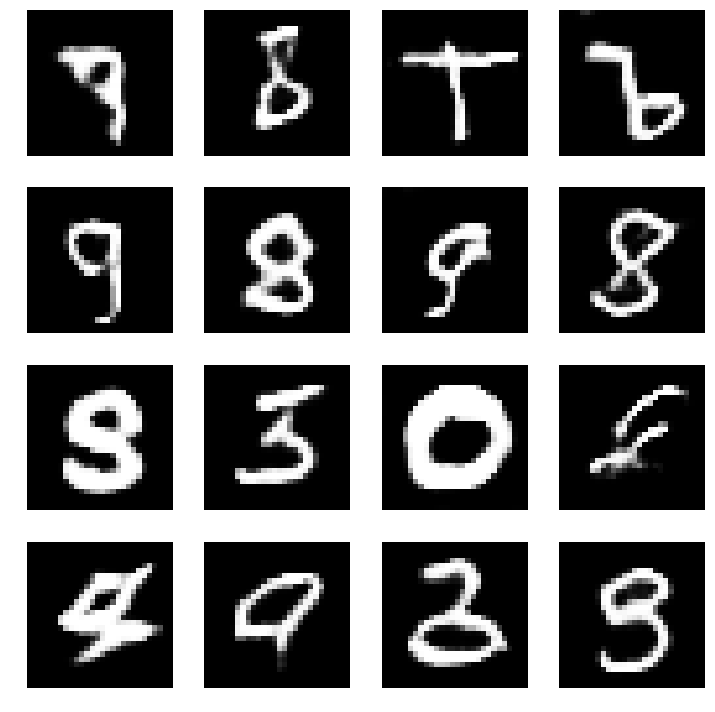

In [12]:
mnist_dcgan.train(train_steps=8000, batch_size=256, save_interval=500)
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)

In [16]:
x1 = np.arange(4).reshape((2, 2))
x2 = np.ones(6).reshape((3, 2))

In [17]:
x1

array([[0, 1],
       [2, 3]])

In [18]:
x2

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [23]:
x2[None, :, :].shape

(1, 3, 2)

In [25]:
x1[..., None].shape

(2, 2, 1)

In [27]:
np.ones([2,3,2]).shape

(2, 3, 2)

In [28]:
x1[..., None] + x2[None, :, :]

ValueError: operands could not be broadcast together with shapes (2,2,1) (1,3,2) 